In [1]:
import os
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.metrics import r2_score

import joblib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import biomassml

from biomassml.build_model import *
from biomassml.coregionalized_regressor import *
#from biomassml.feature_importance import *
from biomassml.metrics import *
from biomassml.plotting import *
from biomassml.predict import *
from biomassml.utils import *
from biomassml.predict_outputs import *
from biomassml.feature_importance2 import *

In [3]:
import os
import numpy as np 
import pandas as pd

from numpy import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import permutation_importance

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import joblib
import plotly.express as px
%matplotlib inline

import GPy
from GPy import kern, util
from GPy.core import GP
from paramz import ObsAr

In [4]:
DATA_DIR = '/mnt/c/Users/44907688G/Documents/home_vicky/'

def load_data_file(data_dir=DATA_DIR, csv_file=''):
    DATA_FILE = os.path.join(data_dir, csv_file)
    return pd.read_csv(DATA_FILE)

In [5]:
def get_scalers(X, y):
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)
    return x_scaler, y_scaler

In [6]:
def scale_X(X, x_scaler):
    X_scaled = x_scaler.transform(X)
    return X_scaled

In [7]:
def unscale_predictions(predictions, y_scaler):
    unscaled_predictions = y_scaler.inverse_transform(np.column_stack(predictions))
    return unscaled_predictions   

### training GASIF dataset

In [8]:
dfGASIF_dataset = load_data_file(DATA_DIR, 'data_GASIF_biomass2.csv')

In [9]:
dfGASIF_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BIOMASS                30 non-null     object 
 1   BIOMASS_SR             30 non-null     object 
 2   SA                     30 non-null     float64
 3   SBR                    30 non-null     float64
 4   HHVbiom (MJ/kg)        30 non-null     float64
 5   T (K)                  30 non-null     int64  
 6   SR                     30 non-null     float64
 7   He_density (g/cm3)     30 non-null     float64
 8   C (%)                  30 non-null     float64
 9   N (%)                  30 non-null     float64
 10  H (%)                  30 non-null     float64
 11  S (%)                  30 non-null     float64
 12  O (%)                  30 non-null     float64
 13  ash (%)                30 non-null     float64
 14  VM (%)                 30 non-null     float64
 15  FC (%)  

In [10]:
FEATURES_GASIF_12 = pd.concat([dfGASIF_dataset.iloc[:,2:7], dfGASIF_dataset.iloc[:,[8,10,12,13,14,15,16]]], axis=1)
FEATURES_GASIF_12.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC (%)
0,2.33,1.1,19.5649,1173,0.13,49.44,5.85,42.9,1.45,78.93,19.62,6.52


In [11]:
features = list(FEATURES_GASIF_12.columns)
features

['SA',
 'SBR',
 'HHVbiom (MJ/kg)',
 'T (K)',
 'SR',
 'C (%)',
 'H (%)',
 'O (%)',
 'ash (%)',
 'VM (%)',
 'FC (%)',
 'MC (%)']

In [12]:
TARGETS_GASIF_4 = dfGASIF_dataset.iloc[:,[24,26,27,38]]
TARGETS_GASIF_4.head(1)

,volCO (%),volH2 (%),volCOMB (%),Edensity (MJ/kg biom)
0,23.6541,36.4296,67.4756,7.8526


In [13]:
outputs_4 = list(TARGETS_GASIF_4.columns)
outputs_4

['volCO (%)', 'volH2 (%)', 'volCOMB (%)', 'Edensity (MJ/kg biom)']

In [14]:
feature_names = ['SA', 'SBR', 'HHV', 'T', 'SR', 'C', 'H', 'O', 'ash', 'VM', 'FC', 'MC']

In [15]:
output_names_4 = ['CO (vol%)', r'H$_2$ (vol%)', 'COMBgas (vol%)', 'Eyield (MJ/kg biom)']

In [16]:
output_names = ['CO (vol%)', r'H$_2$ (vol%)', 'COMBgas (vol%)', 'Eyield (MJ/kg biom)', r'CH$_4$ (vol%)',
                'SYNGAS (vol%)', r'H$_2$/CO', r'HHVgas (MJ/m$^3$)', r'GASyield (m$^3$/kg biom)', 'CGE (%)']

#### get scalers from training GASIF dataset (12in_4out): x_scaler_12, y_scaler_4

In [17]:
x_scaler_12, y_scaler_4 = get_scalers(FEATURES_GASIF_12, TARGETS_GASIF_4)
print('x_scaler_12')
print(x_scaler_12.scale_)
print(x_scaler_12.mean_)
print(x_scaler_12.var_)
print('y_scaler_4')
print(y_scaler_4.scale_)
print(y_scaler_4.mean_)
print(y_scaler_4.var_)
joblib.dump(x_scaler_12, 'x_scaler_12')
joblib.dump(y_scaler_4, 'y_scaler_4')

x_scaler_12
[ 0.75911352  0.73204622  0.82142774 54.16025603  0.06        2.13491546
  0.34217864  2.47538783  3.27650993  4.05830583  1.72272136  1.77202333]
[1.96000000e+00 1.42500000e+00 2.02378467e+01 1.15300000e+03
 1.90000000e-01 5.11960000e+01 5.92066667e+00 3.96986667e+01
 2.41400000e+00 7.80226667e+01 1.95633333e+01 8.54000000e+00]
[5.76253333e-01 5.35891667e-01 6.74743538e-01 2.93333333e+03
 3.60000000e-03 4.55786400e+00 1.17086222e-01 6.12754489e+00
 1.07355173e+01 1.64698462e+01 2.96776889e+00 3.14006667e+00]
y_scaler_4
[7.27719234 4.17715748 6.46819745 3.47334698]
[30.37474333 32.23867333 72.05633    11.71019   ]
[52.95752832 17.44864465 41.83757831 12.06413925]


['y_scaler_4']

#### get y_scaler from OUTPUTS (11out): y_scaler_11

In [18]:
TARGETS_GASIF_11 = pd.concat([dfGASIF_dataset.iloc[:,23:30], dfGASIF_dataset.iloc[:,36:40]], axis=1)
TARGETS_GASIF_11.head(2)

,volCO2 (%),volCO (%),volCH4 (%),volH2 (%),volCOMB (%),volSYNG (%),H2_CO,HHV (MJ/m3),CGE (%),Edensity (MJ/kg biom),GAS (m3/kg biom)
0,32.5244,23.6541,7.3919,36.4296,67.4756,60.0837,1.5401,9.8471,40.1364,7.8526,0.7975
1,31.0826,26.4786,9.6049,32.8340,68.9174,59.3125,1.2400,10.5713,40.7518,7.7871,0.7366


In [19]:
outputs = list(TARGETS_GASIF_11.columns)
outputs

['volCO2 (%)',
 'volCO (%)',
 'volCH4 (%)',
 'volH2 (%)',
 'volCOMB (%)',
 'volSYNG (%)',
 'H2_CO',
 'HHV (MJ/m3)',
 'CGE (%)',
 'Edensity (MJ/kg biom)',
 'GAS (m3/kg biom)']

In [20]:
_, y_scaler_11 = get_scalers(FEATURES_GASIF_12, TARGETS_GASIF_11)
print('y_scaler_11')
print(y_scaler_11.scale_)
print(y_scaler_11.mean_)
print(y_scaler_11.var_)
joblib.dump(y_scaler_11, 'y_scaler_11')

y_scaler_11
[ 6.46819745  7.27719234  1.37250726  4.17715748  6.46819745  5.56016699
  0.53577682  1.03693841 15.78432973  3.47334698  0.25388598]
[27.94367    30.37474333  9.44290667 32.23867333 72.05633    62.61340667
  1.18146    10.89881667 57.47952    11.71019     1.06113333]
[4.18375783e+01 5.29575283e+01 1.88377619e+00 1.74486447e+01
 4.18375783e+01 3.09154570e+01 2.87056804e-01 1.07524128e+00
 2.49145065e+02 1.20641393e+01 6.44580909e-02]


['y_scaler_11']

#### scaling training GASIF dataset: X_scaled, y_scaled_4

In [21]:
X_scaled = scale_X(FEATURES_GASIF_12, x_scaler_12)
X_scaled = pd.DataFrame(X_scaled, columns=FEATURES_GASIF_12.columns)
X_scaled.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC (%)
0,0.487411,-0.443961,-0.81924,0.369274,-1.0,-0.822515,-0.20652,1.293265,-0.294215,0.223574,0.032894,-1.13994


In [22]:
y_scaled_4 = scale_X(TARGETS_GASIF_4, y_scaler_4)
y_scaled_4 = pd.DataFrame(y_scaled_4, columns=TARGETS_GASIF_4.columns)
y_scaled_4.head(1)

,volCO (%),volH2 (%),volCOMB (%),Edensity (MJ/kg biom)
0,-0.923521,1.003296,-0.708193,-1.110626


#### scaling outputs: y_scaled_11

In [23]:
y_scaled_11 = scale_X(TARGETS_GASIF_11, y_scaler_11)
y_scaled_11 = pd.DataFrame(y_scaled_11, columns=TARGETS_GASIF_11.columns)
y_scaled_11.head(1)

,volCO2 (%),volCO (%),volCH4 (%),volH2 (%),volCOMB (%),volSYNG (%),H2_CO,HHV (MJ/m3),CGE (%),Edensity (MJ/kg biom),GAS (m3/kg biom)
0,0.708193,-0.923521,-1.49435,1.003296,-0.708193,-0.45497,0.669383,-1.014252,-1.098756,-1.110626,-1.038393


#### load model

In [24]:
model = joblib.load('model_12in4outEden_k6e')

### predicted outputs

#### partial dependence plots

In [25]:
class GPYEstimator:
    """Helper to mimic the interface of sklearn.base.BaseEstimator for partial dependency plots"""

    def __init__(self, model, i, x_scaler, y_scaler_4):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.i = i
        self.x_scaler = x_scaler
        self.y_scaler_4 = y_scaler_4

    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)
        ...

    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu = predict_coregionalized(
            self.model, X, self.i)[0]*sqrt(self.y_scaler_4.var_[self.i]) + self.y_scaler_4.mean_[self.i]
        return y_pred_mu.flatten()

In [26]:
def pdp_plots(X=FEATURES_GASIF_12, output_names_4=output_names_4, x_scaler_12=x_scaler_12, y_scaler_4=y_scaler_4,
              featureX=0, featureY=3,):
    n1=0
    n2=1
    n3=2
    n4=3
    features_plot=[(featureX, featureY)]
    model_CO = GPYEstimator(model, n1, x_scaler_12, y_scaler_4)
    model_H2 = GPYEstimator(model, n2, x_scaler_12, y_scaler_4)
    model_COMB = GPYEstimator(model, n3, x_scaler_12, y_scaler_4)
    model_GAS = GPYEstimator(model, n4, x_scaler_12, y_scaler_4)

    contour_kw = {
        'cmap': 'RdBu_r',
        'alpha': 0.8,
    }

    fig, ax = plt.subplots(1, 4, figsize=(10,5), sharey=True)

    PartialDependenceDisplay.from_estimator(estimator=model_CO, X=X, features=features_plot, ax=[ax[0]], 
                                            contour_kw=contour_kw)
    ax[0].set_title(output_names_4[n1], fontsize=14)

    PartialDependenceDisplay.from_estimator(estimator=model_H2, X=X, features=features_plot, ax=[ax[1]], 
                                            contour_kw=contour_kw)
    ax[1].set_title(output_names_4[n2], fontsize=14)
    ax[1].set_ylabel(None)

    PartialDependenceDisplay.from_estimator(estimator=model_COMB, X=X, features=features_plot, ax=[ax[2]], 
                                            contour_kw=contour_kw)
    ax[2].set_title(output_names_4[n3], fontsize=14)
    ax[2].set_ylabel(None)
    
    PartialDependenceDisplay.from_estimator(estimator=model_GAS, X=X, features=features_plot, ax=[ax[3]], 
                                            contour_kw=contour_kw)
    ax[3].set_title(output_names_4[n4], fontsize=14)
    ax[3].set_ylabel(None)

    fig.tight_layout(w_pad=1.5)
    plt.show()

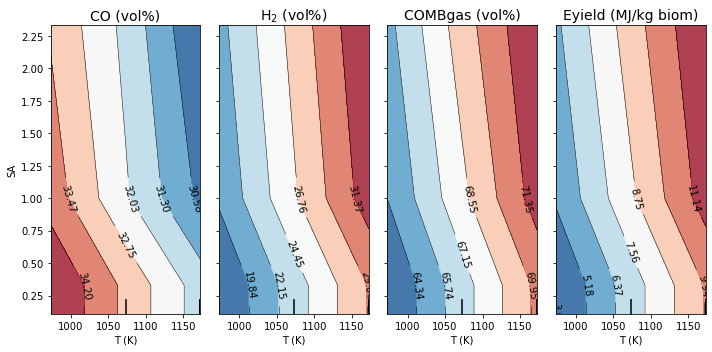

In [27]:
pdp_plots(X=FEATURES_GASIF_12, output_names_4=output_names_4, featureX=3, featureY=0)

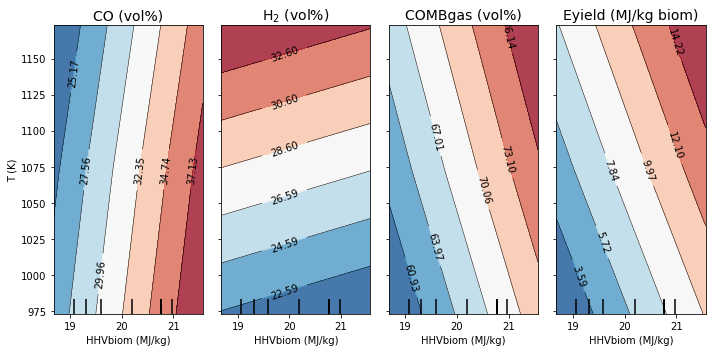

In [28]:
pdp_plots(X=FEATURES_GASIF_12, output_names_4=output_names_4, featureX=2, featureY=3)

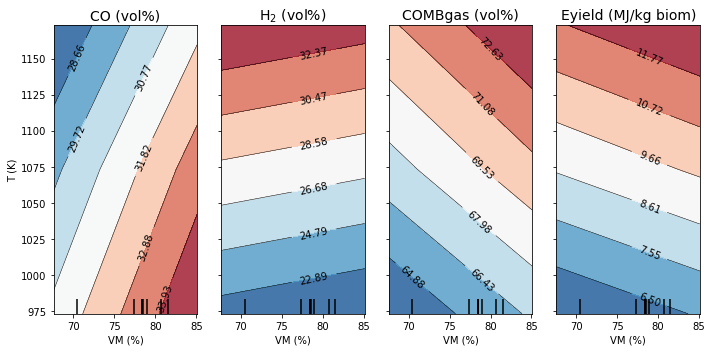

In [29]:
pdp_plots(X=FEATURES_GASIF_12, output_names_4=output_names_4, featureX=9, featureY=3)

#### SHAP summary plots

In [30]:
def plot_shap(shap_values, X_scaled, feature_names, output_names, n_output):
    shap.summary_plot(shap_values=shap_values,
                      features=X_scaled, 
                      feature_names = feature_names,
                      max_display=12, plot_type='dot', plot_size=(4,4.5),
                      show=False, cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(30)
    plt.xlabel('-       SHAP value       +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [31]:
def plotbar_shap(shap_values, X_scaled, feature_names, output_names, n_output):
    shap.summary_plot(shap_values=shap_values,
                      features=X_scaled, 
                      feature_names = feature_names,
                      max_display=12, plot_type='bar', plot_size=(4,4.5),
                      show=False, color='#124984')
    plt.title(output_names[n_output], fontsize=18)
    plt.tight_layout()
    plt.show()

In [32]:
def plotviolin_shap(shap_values, X_scaled, feature_names, output_names, n_output):
    shap.summary_plot(shap_values=shap_values,
                      features=X_scaled,
                      feature_names = feature_names,
                      max_display=12, plot_type='layered_violin', layered_violin_max_num_bins=4,
                      plot_size=(4,4.5), show=False, 
                      cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(30)
    plt.xlabel('-          SHAP value          +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [33]:
def plot_shap_index(shap_values, X_scaled, feature_names, output_names, n_output, feature_index):
    shap.summary_plot(shap_values=shap_values[:, feature_index],
                      features=X_scaled.iloc[:, feature_index], 
                      feature_names=[feature_names[i] for i in feature_index],
                      max_display=12, plot_type='dot', plot_size=(4,3.5),
                      show=False, cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(25)
    plt.xlabel('-       SHAP value       +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [34]:
feature_names

['SA', 'SBR', 'HHV', 'T', 'SR', 'C', 'H', 'O', 'ash', 'VM', 'FC', 'MC']

In [35]:
def plot_shap_colors(shap_values, X_scaled, feature_names, output_names, n_output):
    colors = ['darkred', 'darkred', '#1a5899', 'darkred', 'darkred',
              '#1a5899','#1a5899', '#1a5899','#1a5899', '#1a5899', '#1a5899', '#1a5899']
    features_ind = np.argsort([-np.abs(shap_values[:,i]).mean() for i in range(shap_values.shape[1])])
    colors = np.array(colors)[features_ind]
    shap.summary_plot(shap_values=shap_values,
                      features=X_scaled, 
                      feature_names = feature_names,
                      max_display=12, plot_type='dot', plot_size=(4,4.5),
                      show=False, cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(30)
    plt.gca().tick_params(labelsize=14.5, labelcolor='dimgray')
    for i in np.arange(len(colors))+1:
        plt.gca().get_yticklabels()[i-1].set_color(colors[-i])
    plt.xlabel('-       SHAP value       +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [36]:
def plot_shap_index_colors(shap_values, X_scaled, feature_names, output_names, n_output, feature_index):
    colors = ['darkred', 'darkred', '#1a5899', 'darkred', 'darkred',
              '#1a5899','#1a5899', '#1a5899','#1a5899', '#1a5899', '#1a5899', '#1a5899']
    colors = np.array(colors)[feature_index]
    features_ind = np.argsort([-np.abs(shap_values[:, feature_index][:,i]).mean() for i in range(
        shap_values[:, feature_index].shape[1])])
    colors = np.array(colors)[features_ind]
    shap.summary_plot(shap_values=shap_values[:, feature_index],
                      features=X_scaled.iloc[:, feature_index], 
                      feature_names=[feature_names[i] for i in feature_index],
                      max_display=12, plot_type='dot', plot_size=(4,3.5),
                      show=False, cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(25)
    plt.gca().tick_params(labelsize=14.5, labelcolor='dimgray')
    for i in np.arange(len(colors))+1:
        plt.gca().get_yticklabels()[i-1].set_color(colors[-i])
    plt.xlabel('-       SHAP value       +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [187]:
n_output=0
shap_values_CO = get_shap_values(model, X_scaled.values, x_scaler=x_scaler_12, y_scaler_11=y_scaler_11, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

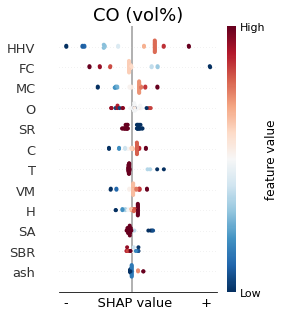

In [413]:
plot_shap(shap_values_CO, X_scaled, feature_names, output_names, 0)

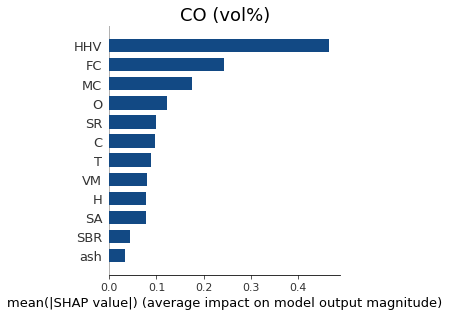

In [417]:
plotbar_shap(shap_values_CO, X_scaled, feature_names, output_names, 0)

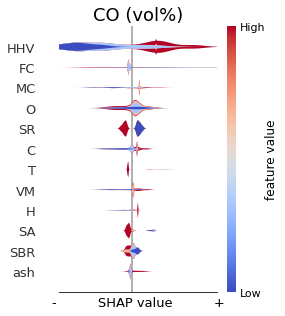

In [418]:
plotviolin_shap(shap_values_CO, X_scaled, feature_names, output_names, 0)

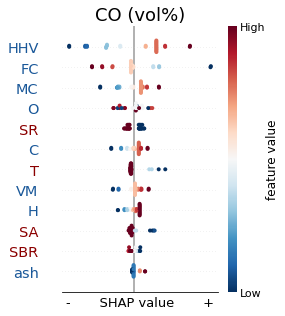

In [414]:
plot_shap_colors(shap_values_CO, X_scaled, feature_names, output_names, 0)

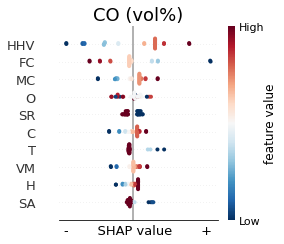

In [419]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index(shap_values_CO, X_scaled, feature_names, output_names, 0, feature_index)

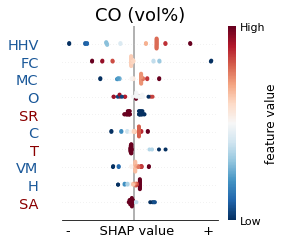

In [416]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_CO, X_scaled, feature_names, output_names, 0, feature_index)

In [420]:
n_output=1
shap_values_H2 = get_shap_values(model, X_scaled.values, x_scaler=x_scaler_12, y_scaler_11=y_scaler_11, index=n_output, 
                                 custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

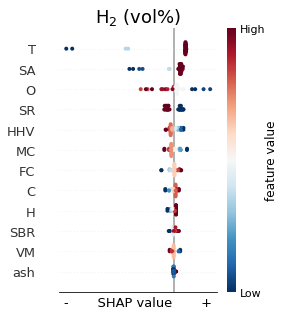

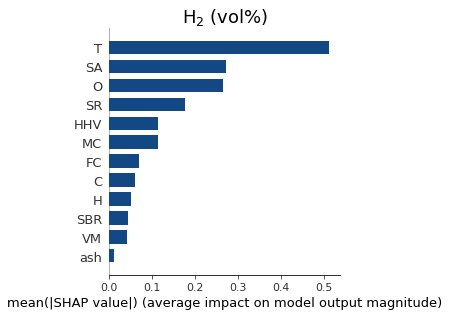

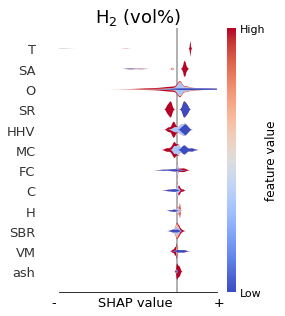

In [421]:
plot_shap(shap_values_H2, X_scaled, feature_names, output_names, 1)
plotbar_shap(shap_values_H2, X_scaled, feature_names, output_names, 1)
plotviolin_shap(shap_values_H2, X_scaled, feature_names, output_names, 1)

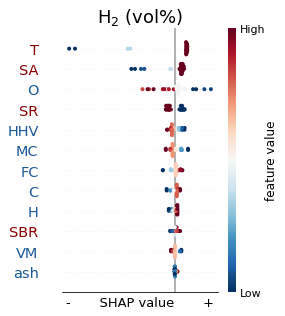

In [422]:
plot_shap_colors(shap_values_H2, X_scaled, feature_names, output_names, 1)

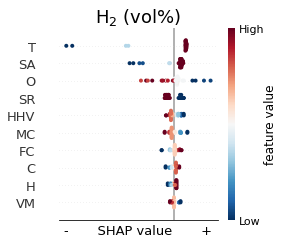

In [423]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index(shap_values_H2, X_scaled, feature_names, output_names, 1, feature_index)

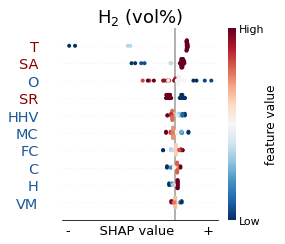

In [424]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_H2, X_scaled, feature_names, output_names, 1, feature_index)

In [425]:
n_output=2
shap_values_COMB = get_shap_values(model, X_scaled.values, x_scaler=x_scaler_12, y_scaler_11=y_scaler_11, index=n_output,
                                   custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

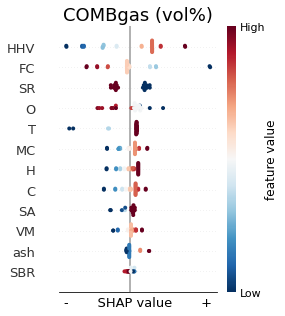

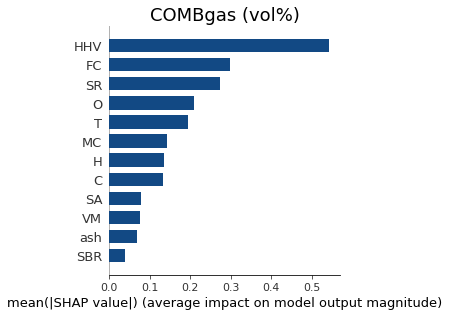

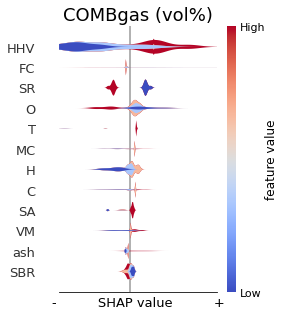

In [426]:
plot_shap(shap_values_COMB, X_scaled, feature_names, output_names, 2)
plotbar_shap(shap_values_COMB, X_scaled, feature_names, output_names, 2)
plotviolin_shap(shap_values_COMB, X_scaled, feature_names, output_names, 2)

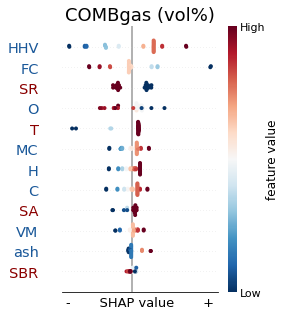

In [427]:
plot_shap_colors(shap_values_COMB, X_scaled, feature_names, output_names, 2)

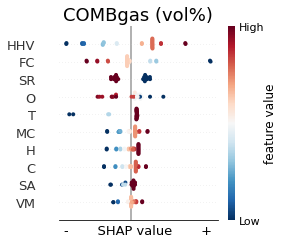

In [428]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index(shap_values_COMB, X_scaled, feature_names, output_names, 2, feature_index)

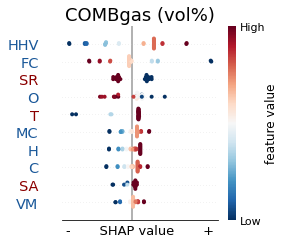

In [429]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_COMB, X_scaled, feature_names, output_names, 2, feature_index)

In [430]:
n_output=3
shap_values_Edens = get_shap_values(model, X_scaled.values, x_scaler=x_scaler_12, y_scaler_11=y_scaler_11, index=n_output, 
                                    custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

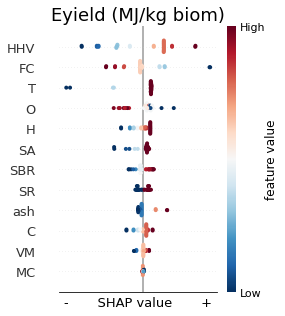

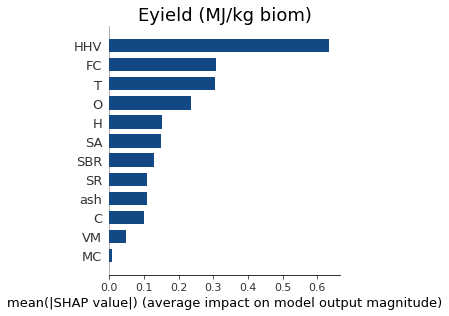

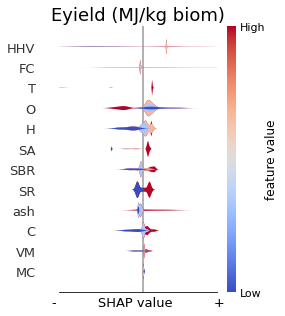

In [431]:
plot_shap(shap_values_Edens, X_scaled, feature_names, output_names, 3)
plotbar_shap(shap_values_Edens, X_scaled, feature_names, output_names, 3)
plotviolin_shap(shap_values_Edens, X_scaled, feature_names, output_names, 3)

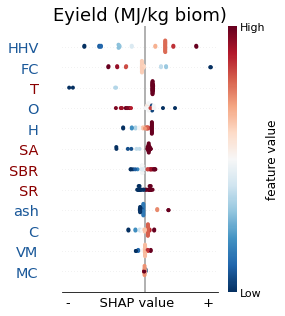

In [433]:
plot_shap_colors(shap_values_Edens, X_scaled, feature_names, output_names, 3)

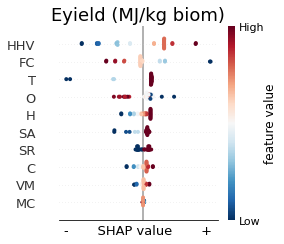

In [434]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index(shap_values_Edens, X_scaled, feature_names, output_names, 3, feature_index)

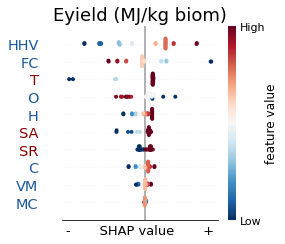

In [435]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_Edens, X_scaled, feature_names, output_names, 3, feature_index)

### calculated outputs

In [436]:
def pdp_plot(GPYEstimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=0,
             x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=0, featureY=3):
    features_plot=[(featureX, featureY)]
    model_n = GPYEstimator(model, x_scaler_12, y_scaler_11)

    contour_kw = {
        'cmap': 'RdBu_r',
        'alpha': 0.8,
    }

    fig, ax = plt.subplots(1, 1, figsize=(3.05,5))

    PartialDependenceDisplay.from_estimator(estimator=model_n, X=X, features=features_plot, ax=ax, 
                                            contour_kw=contour_kw)
    plt.title(output_names[n_output], fontsize=14)
    ax.set_ylabel(None)
    fig.tight_layout(w_pad=1)
    plt.show()

#### CH4 predictions

In [37]:
def get_shap_values(model, X, x_scaler, y_scaler_11,
                    index: int = 0, custom_wrapper=None, coregionalized: bool = False):
    """
    Get SHAP values for a given model and data.
    """
    if custom_wrapper is None:
        explainer = shap.KernelExplainer(
            lambda X: predict_wrapper(model, X, index=index, coregionalized=coregionalized), X
        )
    else:
        explainer = shap.KernelExplainer(lambda X: custom_wrapper(model, X, x_scaler, y_scaler_11), X)
    shap_values = explainer.shap_values(X)
    return shap_values

In [38]:
TARGETS_GASIF_11.columns[2]

'volCH4 (%)'

In [37]:
class GPY_CH4_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_COMB = predict_coregionalized(self.model, X, 2)[0]*sqrt(self.y_scaler_11.var_[4]) + self.y_scaler_11.mean_[4]
        y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
        return y_pred_mu_CH4.flatten()

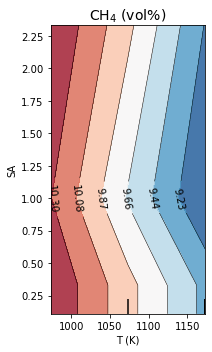

In [437]:
pdp_plot(GPY_CH4_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=4,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)

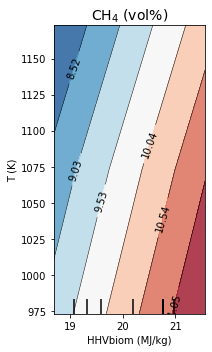

In [34]:
pdp_plot(GPY_CH4_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=4,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)

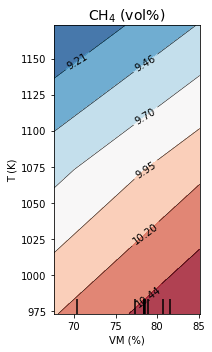

In [272]:
pdp_plot(GPY_CH4_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=4,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [35]:
def custom_wrapper_CH4(model, X, x_scaler, y_scaler_11):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mx_scaler.transform(X)u_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_pred_mu_CH4_scaled = ((y_pred_mu_CH4 - y_scaler_11.mean_[2])/sqrt(y_scaler_11.var_[2])).flatten() 
    return y_pred_mu_CH4_scaled

In [438]:
shap_values_CH4 = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11, 
                                  custom_wrapper=custom_wrapper_CH4)

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/30 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

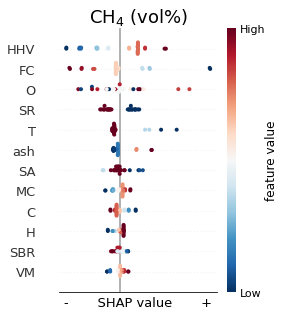

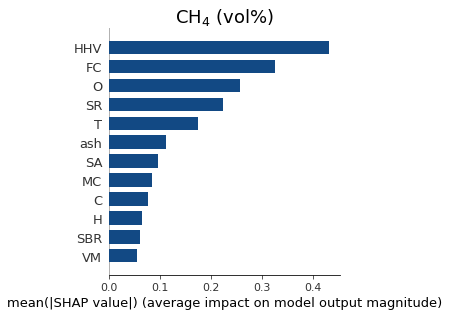

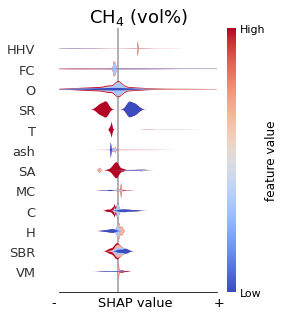

In [439]:
plot_shap(shap_values_CH4, X_scaled, feature_names, output_names, 4)
plotbar_shap(shap_values_CH4, X_scaled, feature_names, output_names, 4)
plotviolin_shap(shap_values_CH4, X_scaled, feature_names, output_names, 4)

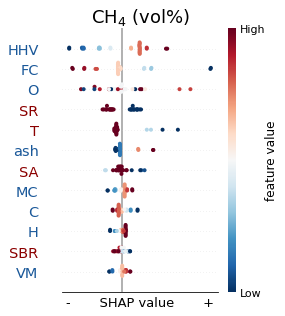

In [440]:
plot_shap_colors(shap_values_CH4, X_scaled, feature_names, output_names, 4)

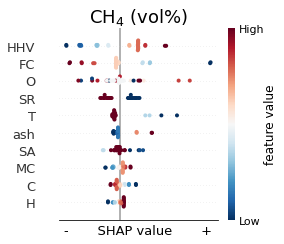

In [441]:
feature_index = [0,2,3,4,5,6,7,8,10,11]
plot_shap_index(shap_values_CH4, X_scaled, feature_names, output_names, 4, feature_index)

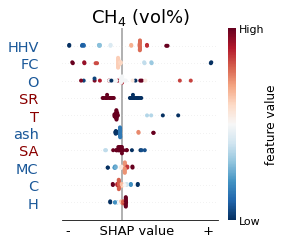

In [442]:
feature_index = [0,2,3,4,5,6,7,8,10,11]
plot_shap_index_colors(shap_values_CH4, X_scaled, feature_names, output_names, 4, feature_index)

#### volSYNG predictions

In [443]:
TARGETS_GASIF_11.columns[5]

'volSYNG (%)'

In [444]:
class GPY_SYNG_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_SYNG = y_pred_mu_CO + y_pred_mu_H2
        return y_pred_mu_SYNG.flatten()

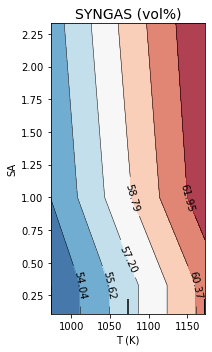

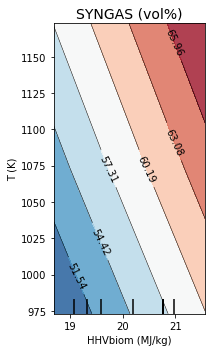

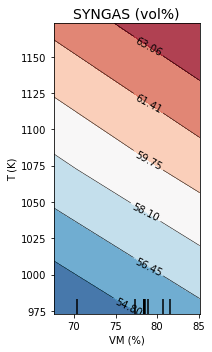

In [445]:
pdp_plot(GPY_SYNG_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=5,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)
pdp_plot(GPY_SYNG_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=5,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)
pdp_plot(GPY_SYNG_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=5,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [446]:
def custom_wrapper_SYNG(model, X, x_scaler, y_scaler_11):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_SYNG = y_pred_mu_CO + y_pred_mu_H2
    y_pred_mu_SYNG_scaled = ((y_pred_mu_SYNG - y_scaler_11.mean_[5])/sqrt(y_scaler_11.var_[5])).flatten() 
    return y_pred_mu_SYNG_scaled

In [447]:
shap_values_SYNG = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11,
                                   custom_wrapper=custom_wrapper_SYNG)

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/30 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

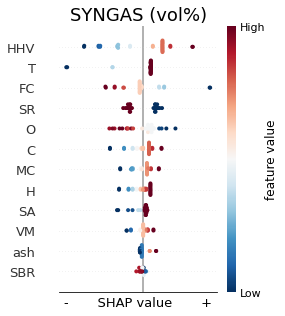

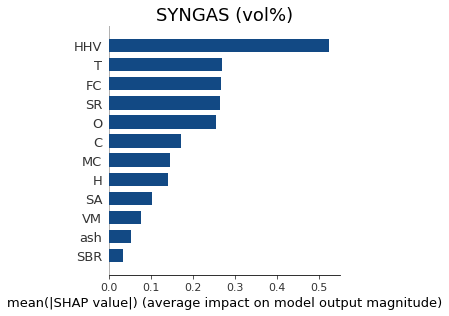

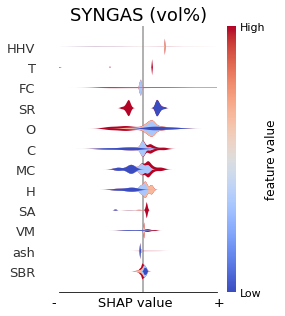

In [448]:
plot_shap(shap_values_SYNG, X_scaled, feature_names, output_names, 5)
plotbar_shap(shap_values_SYNG, X_scaled, feature_names, output_names, 5)
plotviolin_shap(shap_values_SYNG, X_scaled, feature_names, output_names, 5)

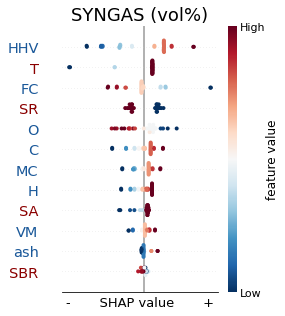

In [449]:
plot_shap_colors(shap_values_SYNG, X_scaled, feature_names, output_names, 5)

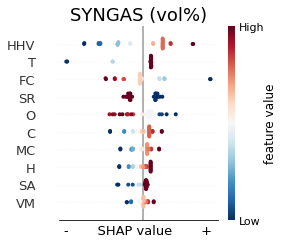

In [450]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index(shap_values_SYNG, X_scaled, feature_names, output_names, 5, feature_index)

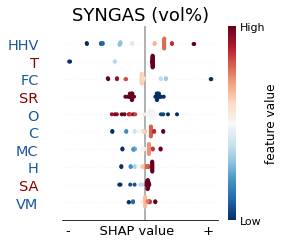

In [451]:
feature_index = [0,2,3,4,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_SYNG, X_scaled, feature_names, output_names, 5, feature_index)

#### H2/CO predictions

In [129]:
TARGETS_GASIF_11.columns[6]

'H2_CO'

In [44]:
class GPY_H2CO_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_H2CO = y_pred_mu_H2 / y_pred_mu_CO
        return y_pred_mu_H2CO.flatten()

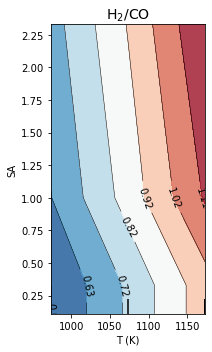

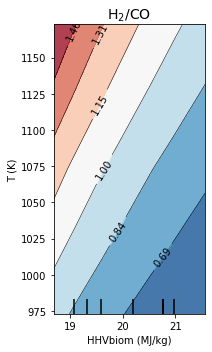

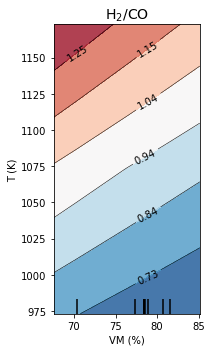

In [35]:
pdp_plot(GPY_H2CO_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=6,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)
pdp_plot(GPY_H2CO_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=6,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)
pdp_plot(GPY_H2CO_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=6,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [41]:
def custom_wrapper_H2CO(model, X, x_scaler, y_scaler_11):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_H2CO = y_pred_mu_H2 / y_pred_mu_CO
    y_pred_mu_H2CO_scaled = ((y_pred_mu_H2CO - y_scaler_11.mean_[6])/sqrt(y_scaler_11.var_[6])).flatten() 
    return y_pred_mu_H2CO_scaled

In [452]:
shap_values_H2CO = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11,
                                   custom_wrapper=custom_wrapper_H2CO)

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/30 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

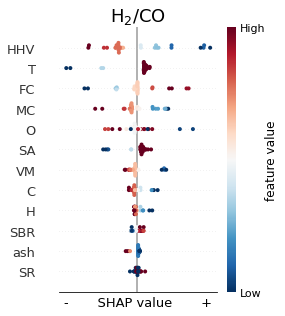

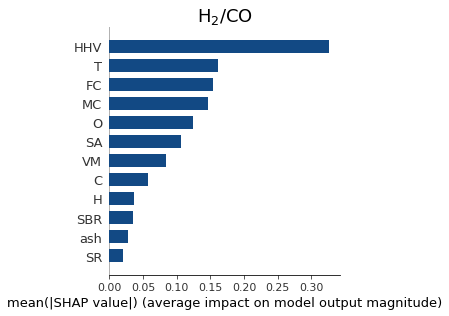

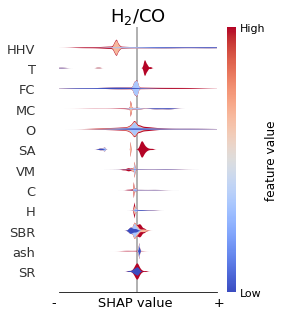

In [453]:
plot_shap(shap_values_H2CO, X_scaled, feature_names, output_names, 6)
plotbar_shap(shap_values_H2CO, X_scaled, feature_names, output_names, 6)
plotviolin_shap(shap_values_H2CO, X_scaled, feature_names, output_names, 6)

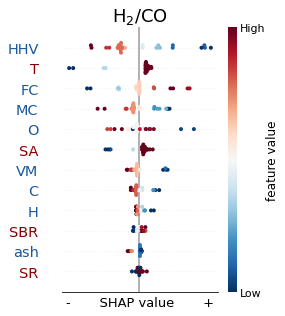

In [455]:
plot_shap_colors(shap_values_H2CO, X_scaled, feature_names, output_names, 6)

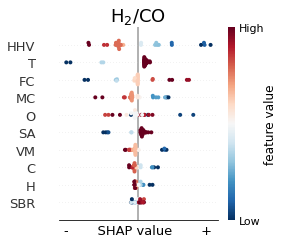

In [456]:
feature_index = [0,1,2,3,5,6,7,9,10,11]
plot_shap_index(shap_values_H2CO, X_scaled, feature_names, output_names, 6, feature_index)

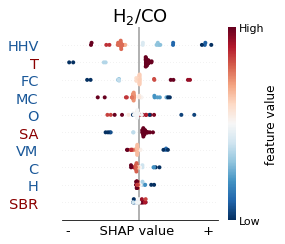

In [457]:
feature_index = [0,1,2,3,5,6,7,9,10,11]
plot_shap_index_colors(shap_values_H2CO, X_scaled, feature_names, output_names, 6, feature_index)

#### HHV predictions

In [143]:
TARGETS_GASIF_11.columns[7]

'HHV (MJ/m3)'

In [47]:
class GPY_HHV_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_COMB = predict_coregionalized(self.model, X, 2)[0]*sqrt(self.y_scaler_11.var_[4]) + self.y_scaler_11.mean_[4]
        y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
        y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
        return y_pred_mu_HHV.flatten()

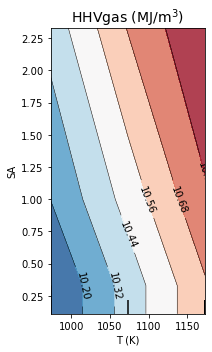

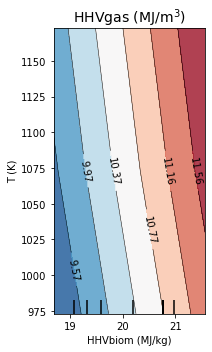

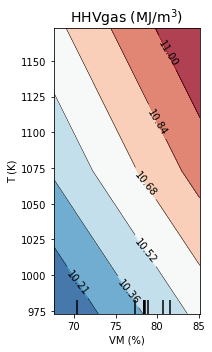

In [48]:
pdp_plot(GPY_HHV_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=7,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)
pdp_plot(GPY_HHV_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=7,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)
pdp_plot(GPY_HHV_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=7,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [49]:
def custom_wrapper_HHV(model, X, x_scaler, y_scaler_11):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
    y_pred_mu_HHV_scaled = ((y_pred_mu_HHV - y_scaler_11.mean_[7])/sqrt(y_scaler_11.var_[7])).flatten()
    return y_pred_mu_HHV_scaled

In [458]:
shap_values_HHV = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11,
                                  custom_wrapper=custom_wrapper_HHV)

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/30 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

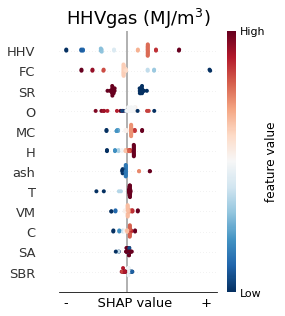

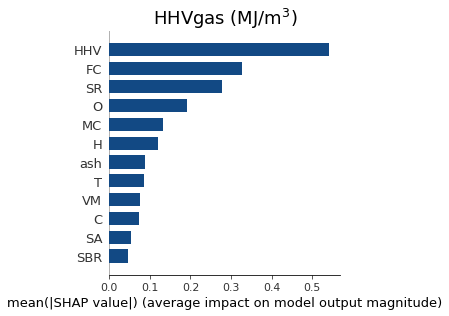

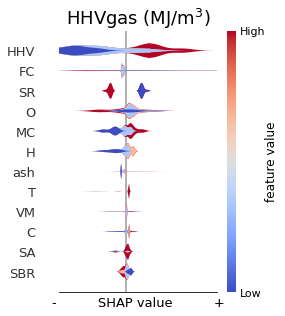

In [459]:
plot_shap(shap_values_HHV, X_scaled, feature_names, output_names, 7)
plotbar_shap(shap_values_HHV, X_scaled, feature_names, output_names, 7)
plotviolin_shap(shap_values_HHV, X_scaled, feature_names, output_names, 7)

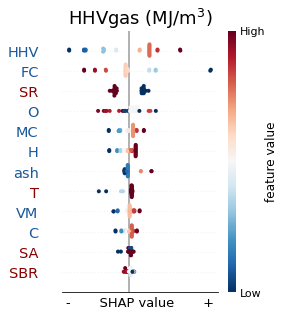

In [460]:
plot_shap_colors(shap_values_HHV, X_scaled, feature_names, output_names, 7)

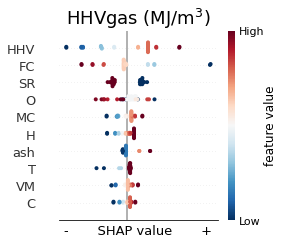

In [461]:
feature_index = [2,3,4,5,6,7,8,9,10,11]
plot_shap_index(shap_values_HHV, X_scaled, feature_names, output_names, 7, feature_index)

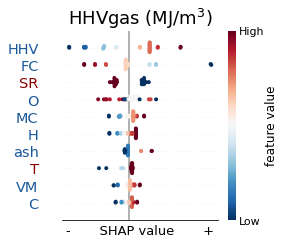

In [462]:
feature_index = [2,3,4,5,6,7,8,9,10,11]
plot_shap_index_colors(shap_values_HHV, X_scaled, feature_names, output_names, 7, feature_index)

#### GAS predictions

In [51]:
TARGETS_GASIF_11.columns[10]

'GAS (m3/kg biom)'

In [52]:
class GPY_GAS_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_COMB = predict_coregionalized(self.model, X, 2)[0]*sqrt(self.y_scaler_11.var_[4]) + self.y_scaler_11.mean_[4]
        y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
        y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
        y_pred_mu_Edens = predict_coregionalized(
            self.model, X, 3)[0]*sqrt(self.y_scaler_11.var_[9]) + self.y_scaler_11.mean_[9] 
        y_pred_mu_GAS = y_pred_mu_Edens / y_pred_mu_HHV
        return y_pred_mu_GAS.flatten()

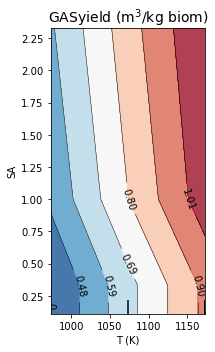

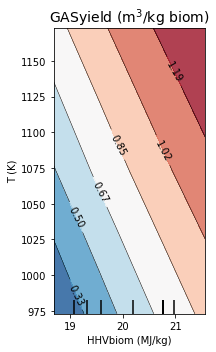

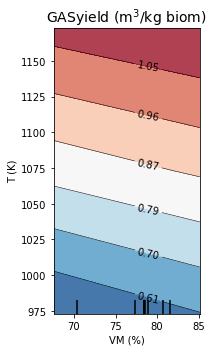

In [56]:
pdp_plot(GPY_GAS_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=8,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)
pdp_plot(GPY_GAS_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=8,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)
pdp_plot(GPY_GAS_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=8,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [468]:
def custom_wrapper_GAS(model, X, x_scaler, y_scaler_11):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
    y_pred_mu_Edens = predict_coregionalized(model, X, 3)[0]*sqrt(y_scaler_11.var_[9]) + y_scaler_11.mean_[9] 
    y_pred_mu_GAS = y_pred_mu_Edens / y_pred_mu_HHV
    y_pred_mu_GAS_scaled = ((y_pred_mu_GAS - y_scaler_11.mean_[10])/sqrt(y_scaler_11.var_[10])).flatten()
    return y_pred_mu_GAS_scaled

In [469]:
shap_values_GAS = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11,
                                  custom_wrapper=custom_wrapper_GAS)

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/30 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

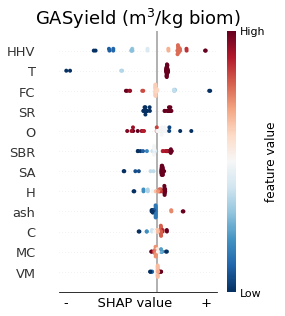

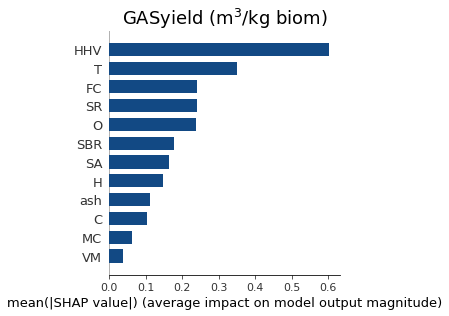

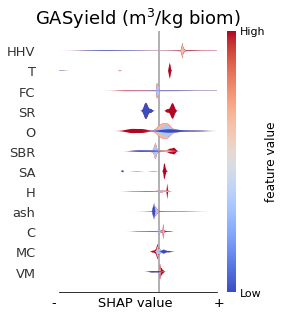

In [470]:
plot_shap(shap_values_GAS, X_scaled, feature_names, output_names, 8)
plotbar_shap(shap_values_GAS, X_scaled, feature_names, output_names, 8)
plotviolin_shap(shap_values_GAS, X_scaled, feature_names, output_names, 8)

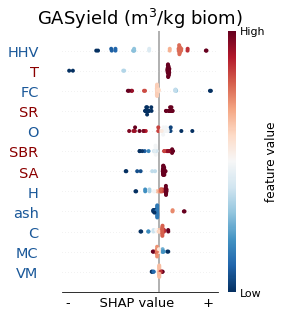

In [471]:
plot_shap_colors(shap_values_GAS, X_scaled, feature_names, output_names, 8)

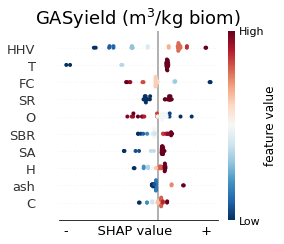

In [472]:
feature_index = [0,1,2,3,4,5,6,7,8,10]
plot_shap_index(shap_values_GAS, X_scaled, feature_names, output_names, 8, feature_index)

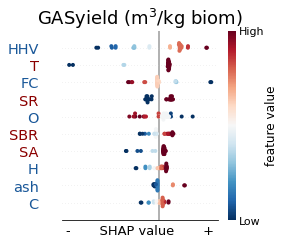

In [473]:
feature_index = [0,1,2,3,4,5,6,7,8,10]
plot_shap_index_colors(shap_values_GAS, X_scaled, feature_names, output_names, 8, feature_index)

#### CGE predictions

In [62]:
TARGETS_GASIF_11.columns[8]

'CGE (%)'

In [64]:
class GPY_CGE_Estimator:
    
    def __init__(self, model, x_scaler, y_scaler_11, HHVbiom=FEATURES_GASIF_12['HHVbiom (MJ/kg)']):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler_11 = y_scaler_11
        self.HHVbiom = HHVbiom
        
    def fit(self, X, y):
        X = scale_X(X, self.x_scaler)  # not sure if this is needed
        ...
        
    def predict(self, X):
        X = scale_X(X, self.x_scaler)
        y_pred_mu_CO = predict_coregionalized(self.model, X, 0)[0]*sqrt(self.y_scaler_11.var_[1]) + self.y_scaler_11.mean_[1]
        y_pred_mu_H2 = predict_coregionalized(self.model, X, 1)[0]*sqrt(self.y_scaler_11.var_[3]) + self.y_scaler_11.mean_[3]
        y_pred_mu_COMB = predict_coregionalized(self.model, X, 2)[0]*sqrt(self.y_scaler_11.var_[4]) + self.y_scaler_11.mean_[4]
        y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
        y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
        y_pred_mu_Edens = predict_coregionalized(
            self.model, X, 3)[0]*sqrt(self.y_scaler_11.var_[9]) + self.y_scaler_11.mean_[9] 
        y_pred_mu_GAS = y_pred_mu_Edens / y_pred_mu_HHV
        y_pred_mu_CGE = y_pred_mu_GAS * y_pred_mu_HHV / np.reshape(self.HHVbiom.values, (-1,1))*100
        return y_pred_mu_CGE.flatten()

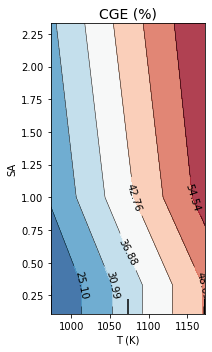

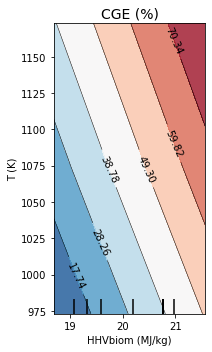

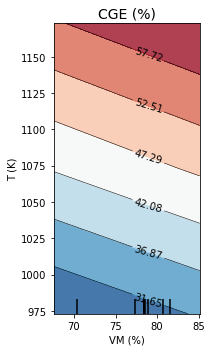

In [65]:
pdp_plot(GPY_CGE_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=9,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=3, featureY=0)
pdp_plot(GPY_CGE_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=9,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=2, featureY=3)
pdp_plot(GPY_CGE_Estimator, X=FEATURES_GASIF_12, output_names=output_names, n_output=9,
         x_scaler_12=x_scaler_12, y_scaler_11=y_scaler_11, featureX=9, featureY=3)

In [68]:
def custom_wrapper_CGE(model, X, x_scaler, y_scaler_11, HHVbiom=FEATURES_GASIF_12['HHVbiom (MJ/kg)']):
    X = x_scaler.transform(X)
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_pred_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_pred_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_pred_mu_CH4)/100
    y_pred_mu_Edens = predict_coregionalized(model, X, 3)[0]*sqrt(y_scaler_11.var_[9]) + y_scaler_11.mean_[9] 
    y_pred_mu_GAS = y_pred_mu_Edens / y_pred_mu_HHV
    y_pred_mu_CGE = y_pred_mu_GAS * y_pred_mu_HHV / np.reshape(HHVbiom.values, (-1,1))*100
    y_pred_mu_CGE_scaled = ((y_pred_mu_CGE - y_scaler_11.mean_[8])/sqrt(y_scaler_11.var_[8])).flatten()
    return y_pred_mu_CGE_scaled

In [69]:
shap_values_CGE = get_shap_values(model, FEATURES_GASIF_12, x_scaler_12, y_scaler_11,
                                  custom_wrapper=custom_wrapper_CGE)

  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (62160,1) (30,1) 

In [ ]:
plot_shap(shap_values_CGE, X_scaled, feature_names, output_names, 9)
plotbar_shap(shap_values_CGE, X_scaled, feature_names, output_names, 9)
plotviolin_shap(shap_values_CGE, X_scaled, feature_names, output_names, 9)

In [ ]:
plot_shap_colors(shap_values_CGE, X_scaled, feature_names, output_names, 9)

In [ ]:
feature_index = [0,1,2,3,4,5,6,7,8,10]
plot_shap_index(shap_values_CGE, X_scaled, feature_names, output_names, 9, feature_index)

In [ ]:
feature_index = [0,1,2,3,4,5,6,7,8,10]
plot_shap_index_colors(shap_values_CGE, X_scaled, feature_names, output_names, 9, feature_index)

### predictions for NEW BIOMASSES

In [21]:
def predict_newX(X, outputs, x_scaler='x_scaler_12', y_scaler='y_scaler_4', model='model_12in4outEden_k6'):
    x_scaler = joblib.load(x_scaler)
    y_scaler = joblib.load(y_scaler)
    model = joblib.load(model)
    new_X = scaling_X(X, x_scaler)
    predictions = []
    stds = []
    for n in np.arange(0, len(outputs)): 
        predictions_newX = predict_coregionalized(model, new_X, n)
        predictions.append(predictions_newX[0])
        stds.append(predictions_newX[1])
    unscaled_predictions = unscaling_predictions(predictions, y_scaler) 
    df_unscaled_predictions = pd.DataFrame(unscaled_predictions, columns=list(outputs))
    unscaled_stds = np.column_stack(stds)*sqrt(y_scaler.var_)
    stds_columns = ['std0', 'std1', 'std2', 'std3']
    df_unscaled_stds = pd.DataFrame(unscaled_stds, columns=stds_columns[0:len(outputs)])
    df_unscaled_predictions_stds = pd.concat([df_unscaled_predictions, df_unscaled_stds], axis=1)
    return df_unscaled_predictions_stds

In [22]:
def plot_results_new_biomasses_stds(df_predictions_stds, outputs):
    %matplotlib inline
    for n in np.arange(0, len(outputs)):
        values = df_predictions_stds.iloc[:,n].sort_values()
        errors = df_predictions_stds.sort_values(df_predictions_stds.columns[n]).iloc[:,n+len(outputs)]
        xcategories = np.arange(len(values))
        xlabels = list(df_predictions_stds.sort_values(df_predictions_stds.columns[n]).iloc[:,-1])
        plt.figure(figsize=(20, 5))
        plt.bar(xcategories, values, yerr=errors, color='#2F5597', width = 0.6, zorder=3)
        plt.ylabel(df_predictions_stds.columns[n], fontsize=16, weight='bold')
        plt.xticks(xcategories, xlabels, rotation=90, fontsize=12)
        plt.yticks(fontsize=13)
        plt.tick_params(axis='both', bottom=False, left=False)
        plt.grid(axis='y', color='black', zorder=0)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

In [392]:
df_newBIOMASSES = load_data_file(DATA_DIR, 'new_biomasses_inrange.csv')

In [393]:
df_newBIOMASSES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BIOMASS_name        47 non-null     object 
 1   BIOMASS             47 non-null     object 
 2   SA                  47 non-null     float64
 3   SBR                 47 non-null     float64
 4   HHVbiom (MJ/kg)     47 non-null     float64
 5   T (K)               47 non-null     int64  
 6   SR                  47 non-null     float64
 7   He_density (g/cm3)  47 non-null     float64
 8   C (%)               47 non-null     float64
 9   N (%)               47 non-null     float64
 10  H (%)               47 non-null     float64
 11  S (%)               47 non-null     float64
 12  O (%)               47 non-null     float64
 13  ash (%)             47 non-null     float64
 14  VM (%)              47 non-null     float64
 15  FC (%)              47 non-null     float64
 16  MC(%)     

In [475]:
df_newBIOMASSES['BIOMASS']

0       ACA
1       APP
2      AS_1
3      AS_2
4      AS_3
5      AS_4
6      BB_1
7      BB_2
8     CAS_1
9     CAS_2
10      CHP
11    EFB_1
12    EFB_2
13    EFB_3
14    EUC_1
15    EUC_2
16      FRW
17     GB_1
18     GB_2
19      GSE
20      OAK
21     OP_1
22     OP_2
23     PA_1
24     PA_2
25      PAU
26    PEP_1
27    PEP_2
28      PES
29      PIB
30    PIN_1
31    PIN_2
32    PIN_3
33    PIN_4
34    PIS_1
35    PIS_2
36    POP_1
37    POP_2
38      PRP
39      SCB
40      SCG
41    SPR_1
42    SPR_2
43    SSS_1
44    SSS_2
45      VIN
46       WS
Name: BIOMASS, dtype: object

In [476]:
np.arange(0,47)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [489]:
biomass_select = [1,  2,  3,  4,  5,  6,  7, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25,
                  26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46]

In [490]:
len(biomass_select)

35

In [491]:
FEATURES_NEWbiomass_12 = pd.concat([df_newBIOMASSES.iloc[:,2:7], df_newBIOMASSES.iloc[:,[8,10,12,13,14,15,16]]], axis=1)
FEATURES_NEWbiomass_12.head(2)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC(%)
0,2.33,1.7998,21.1,1173,0.25,43.2489,5.9743,47.5448,1.8448,72.4225,25.7327,11.49
1,2.33,2.2683,20.8,1173,0.25,51.4000,6.2900,41.8100,0.2000,80.4000,19.4000,6.40


In [492]:
FEATURES_NEWbiomass_12.shape

(47, 12)

In [493]:
FEATURES_NEWbiomass_12 = pd.concat([df_newBIOMASSES.iloc[biomass_select,2:7], 
                                    df_newBIOMASSES.iloc[biomass_select,[8,10,12,13,14,15,16]]], axis=1)
FEATURES_NEWbiomass_12 = FEATURES_NEWbiomass_12.reset_index(drop=True)
FEATURES_NEWbiomass_12.head(2)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC(%)
0,2.33,2.2683,20.80,1173,0.25,51.40,6.29,41.81,0.20,80.4,19.40,6.40
1,2.33,2.2003,19.05,1173,0.25,50.14,5.95,40.10,3.04,76.1,20.86,7.85


In [494]:
FEATURES_NEWbiomass_12.shape[0]

35

In [495]:
df_unscaled_predictions_stds = predict_newX(FEATURES_NEWbiomass_12, outputs,
                                            'x_scaler_12', 'y_scaler_4', 'model_12in4outEden_k6')

In [496]:
df_unscaled_predictions_stds['BIOMASS'] = df_newBIOMASSES['BIOMASS'][biomass_select].reset_index(drop=True)
df_unscaled_predictions_stds.head(2)

,volCO (%),volH2 (%),volCOMB (%),Edensity (MJ/kg biom),std0,std1,std2,std3,BIOMASS
0,32.949981,31.179758,75.011893,16.879350,0.848640,0.720079,1.051206,1.061101,APP
1,19.363020,34.747282,61.493896,8.252293,2.397083,2.033949,2.779770,1.884406,AS_1


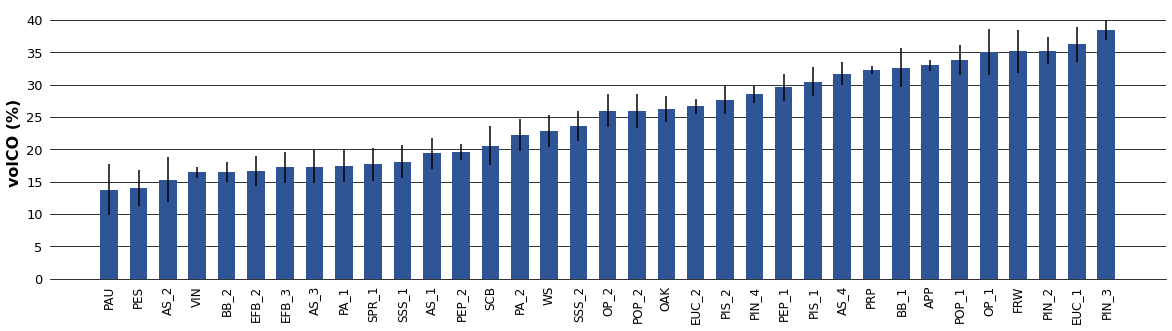

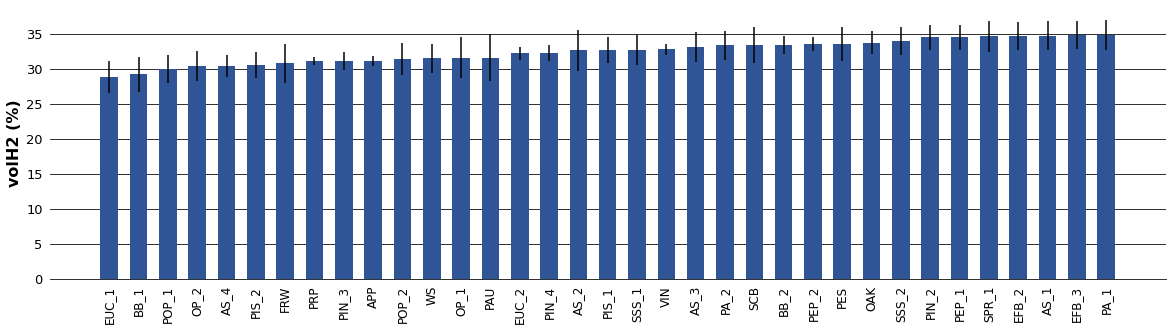

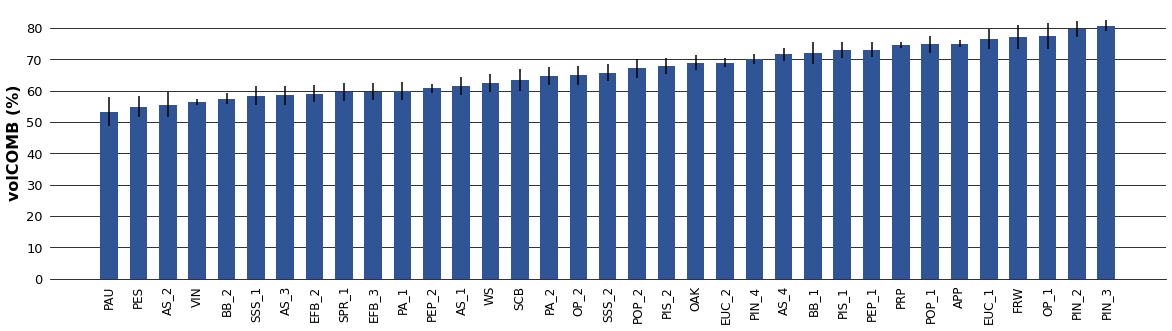

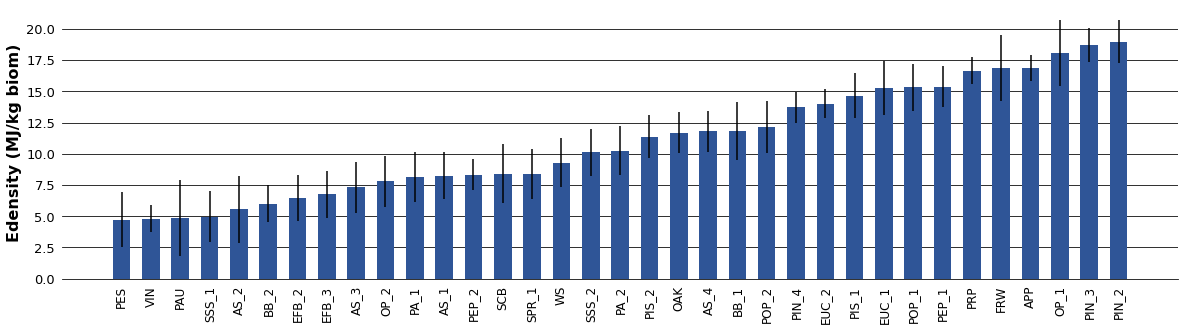

In [497]:
plot_results_new_biomasses_stds(df_unscaled_predictions_stds, outputs)

In [498]:
df_calculated_pred = pd.DataFrame(100 - df_unscaled_predictions_stds['volCOMB (%)'])
df_calculated_pred.rename(columns={'volCOMB (%)':'volCO2 (%)_calc'}, inplace=True)
df_calculated_pred['volCH4 (%)_calc'] = df_unscaled_predictions_stds[
    'volCOMB (%)'] - df_unscaled_predictions_stds['volCO (%)'] - df_unscaled_predictions_stds['volH2 (%)']
df_calculated_pred['volSYNG (%)_calc'] = df_unscaled_predictions_stds[
    'volCO (%)'] + df_unscaled_predictions_stds['volH2 (%)']
df_calculated_pred['H2_CO_calc'] = df_unscaled_predictions_stds[
    'volH2 (%)'] / df_unscaled_predictions_stds['volCO (%)']
df_calculated_pred['HHV (MJ/m3)_calc'] = (11.76*df_unscaled_predictions_stds['volCO (%)'] + 11.882*
                                              df_unscaled_predictions_stds['volH2 (%)'] + 37.024*
                                              df_calculated_pred['volCH4 (%)_calc'])/100
df_calculated_pred['GAS (m3/kg biom)_calc'] = df_unscaled_predictions_stds['Edensity (MJ/kg biom)'] / df_calculated_pred[
    'HHV (MJ/m3)_calc']
df_calculated_pred['CGE(%)_calc'] = df_unscaled_predictions_stds[
    'Edensity (MJ/kg biom)'] / FEATURES_NEWbiomass_12['HHVbiom (MJ/kg)']*100
df_calculated_pred.head(1)

,volCO2 (%)_calc,volCH4 (%)_calc,volSYNG (%)_calc,H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,CGE(%)_calc
0,24.988107,10.882155,64.129739,0.946275,11.608705,1.454025,81.150721


In [499]:
df_calculated_stds = pd.DataFrame(df_unscaled_predictions_stds['std2'])
df_calculated_stds.rename(columns={'std2':'stdCO2_calc'}, inplace=True)
df_calculated_stds['stdCH4_calc'] = sqrt(df_unscaled_predictions_stds['std2']**2 + df_unscaled_predictions_stds[
    'std0']**2 + df_unscaled_predictions_stds['std1']**2)
df_calculated_stds['stdSYNG_calc'] = sqrt(df_unscaled_predictions_stds['std0']**2 + df_unscaled_predictions_stds['std1']**2)

df_calculated_stds['stdH2CO_calc'] = sqrt((df_unscaled_predictions_stds['std1']/df_unscaled_predictions_stds[
    'volH2 (%)'])**2 + (df_unscaled_predictions_stds['std0']/df_unscaled_predictions_stds[
    'volCO (%)'])**2)*df_calculated_pred['H2_CO_calc']

df_calculated_stds['stdHHV_calc'] = sqrt((11.76/100*df_unscaled_predictions_stds[
    'std0'])**2 + (11.882/100*df_unscaled_predictions_stds['std1'])**2 + (37.024/100*df_calculated_stds['stdCH4_calc'])**2)

df_calculated_stds['stdGAS_calc'] = sqrt((df_calculated_stds['stdHHV_calc']/df_calculated_pred[
    'HHV (MJ/m3)_calc'])**2 + (df_unscaled_predictions_stds['std3']/df_unscaled_predictions_stds[
    'Edensity (MJ/kg biom)'])**2)*df_calculated_pred['GAS (m3/kg biom)_calc']

df_calculated_stds['stdCGE_calc'] = df_unscaled_predictions_stds['std3']/FEATURES_NEWbiomass_12['HHVbiom (MJ/kg)']*100
df_calculated_stds.head(1)

,stdCO2_calc,stdCH4_calc,stdSYNG_calc,stdH2CO_calc,stdHHV_calc,stdGAS_calc,stdCGE_calc
0,1.051206,1.530927,1.112971,0.032735,0.581855,0.116903,5.101448


In [500]:
df_calculated_predictions_stds = pd.concat([df_calculated_pred, df_calculated_stds], axis=1)
df_calculated_predictions_stds.head(1)

,volCO2 (%)_calc,volCH4 (%)_calc,volSYNG (%)_calc,H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,CGE(%)_calc,stdCO2_calc,stdCH4_calc,stdSYNG_calc,stdH2CO_calc,stdHHV_calc,stdGAS_calc,stdCGE_calc
0,24.988107,10.882155,64.129739,0.946275,11.608705,1.454025,81.150721,1.051206,1.530927,1.112971,0.032735,0.581855,0.116903,5.101448


In [501]:
df_calculated_predictions_stds['BIOMASS'] = df_newBIOMASSES['BIOMASS'][biomass_select].reset_index(drop=True)
df_calculated_predictions_stds.head(2)

,volCO2 (%)_calc,volCH4 (%)_calc,volSYNG (%)_calc,H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,CGE(%)_calc,stdCO2_calc,stdCH4_calc,stdSYNG_calc,stdH2CO_calc,stdHHV_calc,stdGAS_calc,stdCGE_calc,BIOMASS
0,24.988107,10.882155,64.129739,0.946275,11.608705,1.454025,81.150721,1.051206,1.530927,1.112971,0.032735,0.581855,0.116903,5.101448,APP
1,38.506104,7.383594,54.110302,1.794518,9.139465,0.902930,43.319124,2.779770,4.196436,3.143717,0.245738,1.597442,0.259650,9.891893,AS_1


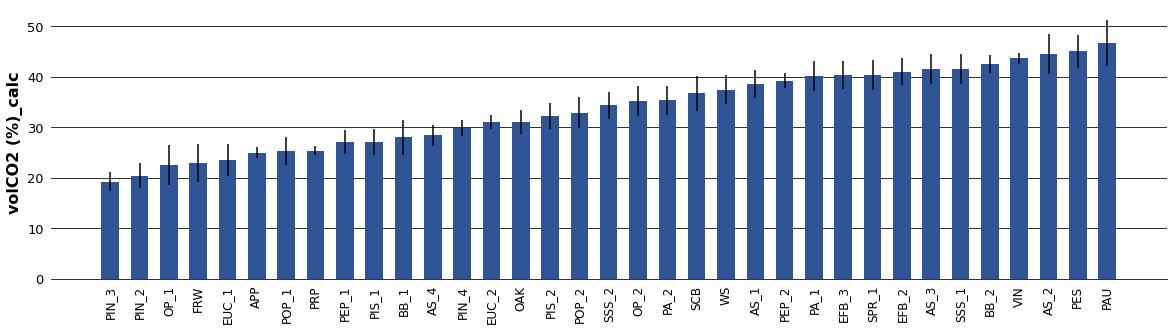

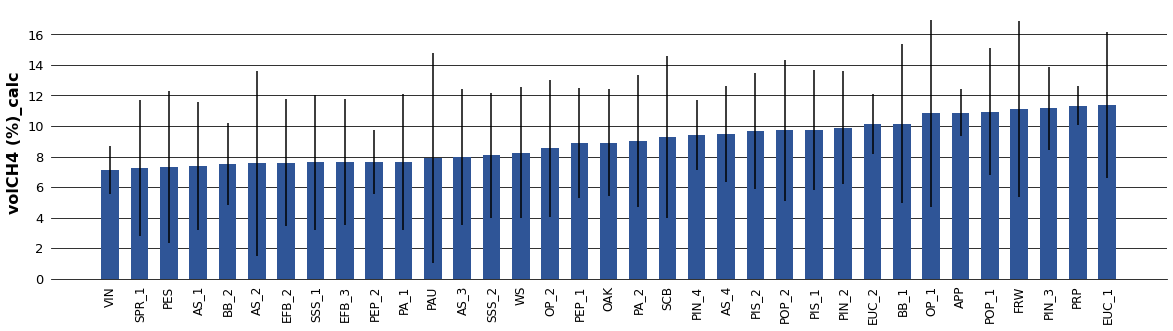

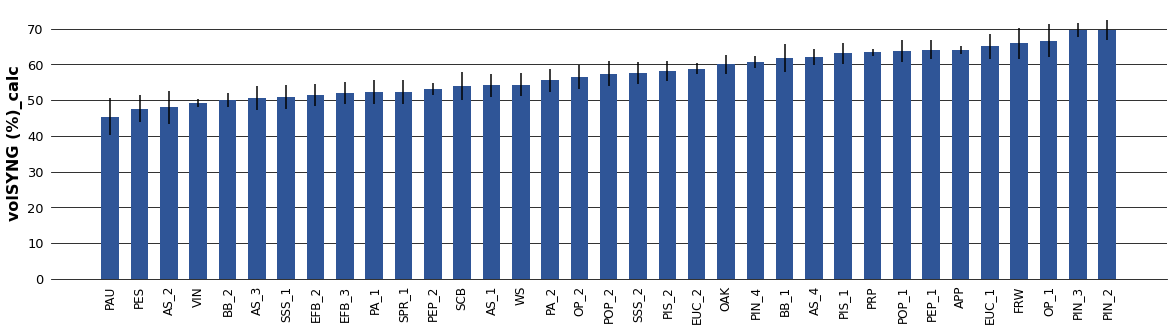

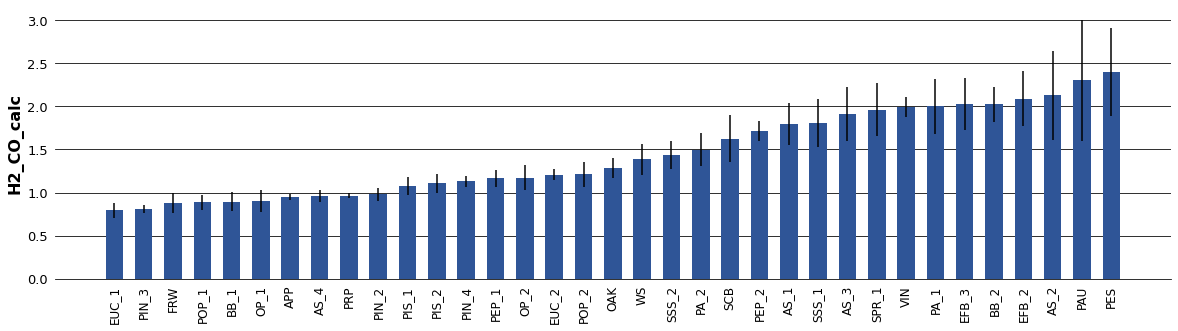

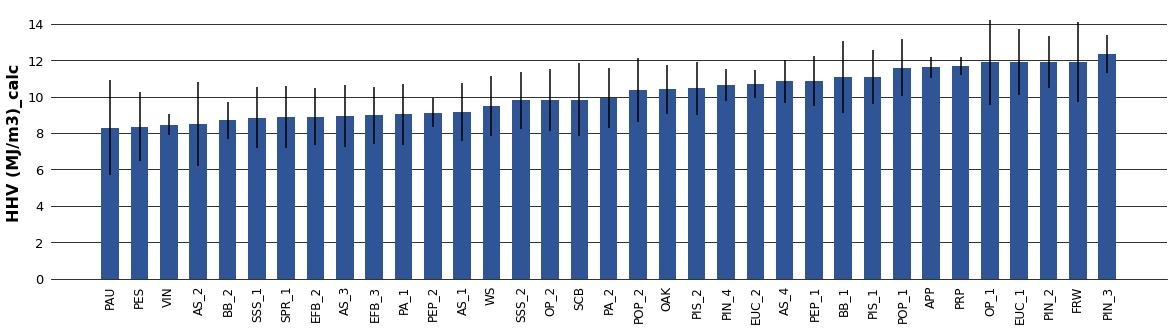

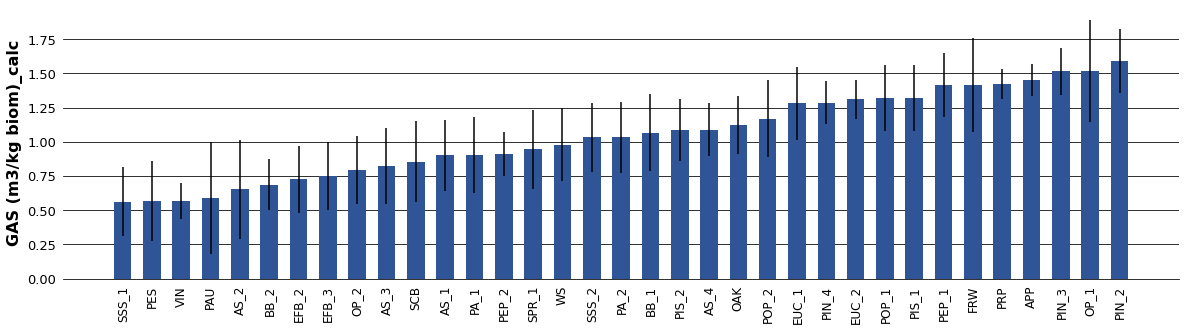

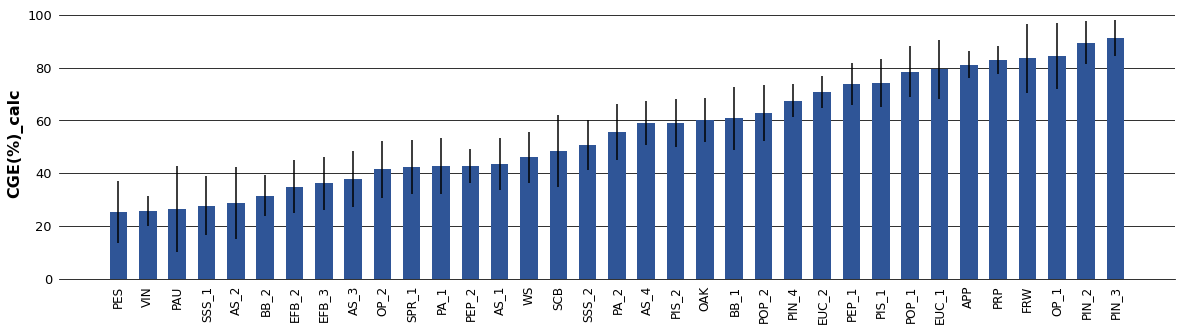

In [502]:
plot_results_new_biomasses_stds(df_calculated_predictions_stds, df_calculated_pred.columns)

In [461]:
df_unscaled_predictions = df_unscaled_predictions_stds.iloc[:,0:4]
df_unscaled_predictions.head(1)

,volCO (%),volH2 (%),volCOMB (%),Edensity (MJ/kg biom)
0,32.949981,31.179758,75.011893,16.87935


In [462]:
df_calculated_predictions = df_calculated_predictions_stds.iloc[:,0:7]
df_calculated_predictions.head(1)

,volCO2 (%)_calc,volCH4 (%)_calc,volSYNG (%)_calc,H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,CGE(%)_calc
0,24.988107,10.882155,64.129739,0.946275,11.608705,1.454025,81.150721


In [463]:
df_predictions = pd.concat([df_unscaled_predictions.iloc[:,0:2], df_calculated_predictions.iloc[:,[1,0,2]],
                            df_unscaled_predictions.iloc[:,2], df_calculated_predictions.iloc[:,3:6],
                            df_unscaled_predictions.iloc[:,3], df_calculated_predictions.iloc[:,6]], axis=1)
df_predictions.head(1)

,volCO (%),volH2 (%),volCH4 (%)_calc,volCO2 (%)_calc,volSYNG (%)_calc,volCOMB (%),H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,Edensity (MJ/kg biom),CGE(%)_calc
0,32.949981,31.179758,10.882155,24.988107,64.129739,75.011893,0.946275,11.608705,1.454025,16.87935,81.150721


In [469]:
df_predictions_biomass = pd.concat([df_predictions, df_newBIOMASSES['BIOMASS'][biomass_select].reset_index(drop=True)],
                                   axis=1)
df_predictions_biomass.head(1)

,volCO (%),volH2 (%),volCH4 (%)_calc,volCO2 (%)_calc,volSYNG (%)_calc,volCOMB (%),H2_CO_calc,HHV (MJ/m3)_calc,GAS (m3/kg biom)_calc,Edensity (MJ/kg biom),CGE(%)_calc,BIOMASS
0,32.949981,31.179758,10.882155,24.988107,64.129739,75.011893,0.946275,11.608705,1.454025,16.87935,81.150721,APP


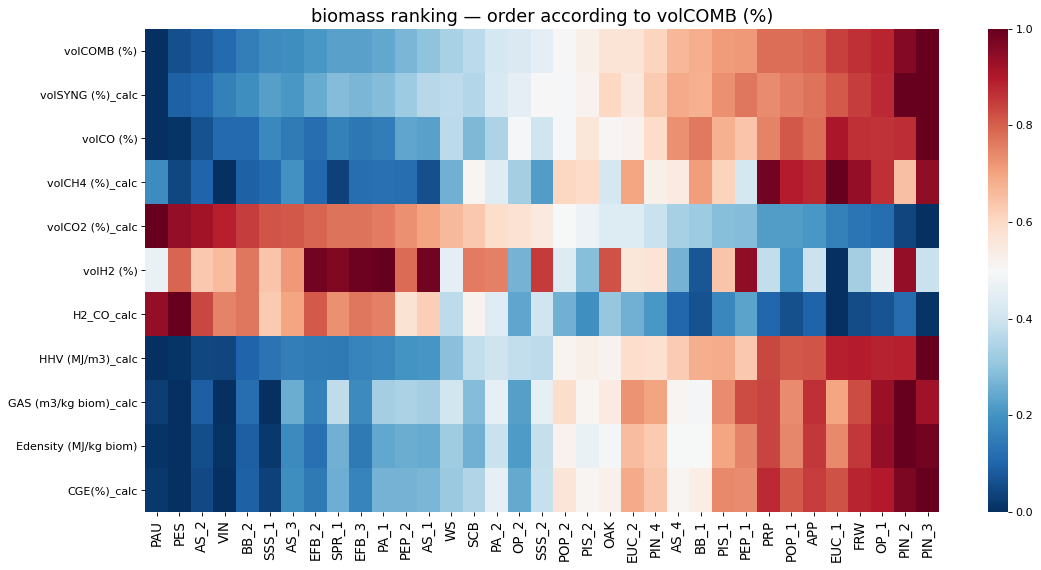

In [470]:
df_order_targets = df_predictions_biomass.iloc[:,[5,4,0,2,3,1,6,7,8,9,10]]
plt.figure(figsize=(16,8), dpi=80)
sns.heatmap(pd.DataFrame.transpose(pd.DataFrame(
    MinMaxScaler().fit_transform(df_order_targets.sort_values('volCOMB (%)', ascending=True)),
    columns=df_order_targets.columns)),
            xticklabels=list(df_predictions_biomass.sort_values('volCOMB (%)')['BIOMASS']),
            yticklabels=df_order_targets.columns,
            cmap='RdBu_r', center=0.5, annot=False, cbar=False)
plt.title('biomass ranking — order according to volCOMB (%)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
norm = plt.Normalize()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdBu_r'), location='right', aspect=25).outline.set_visible(False) 
#plt.savefig('biomass_ranking_COMB.pdf', bbox_inches='tight')
plt.show()

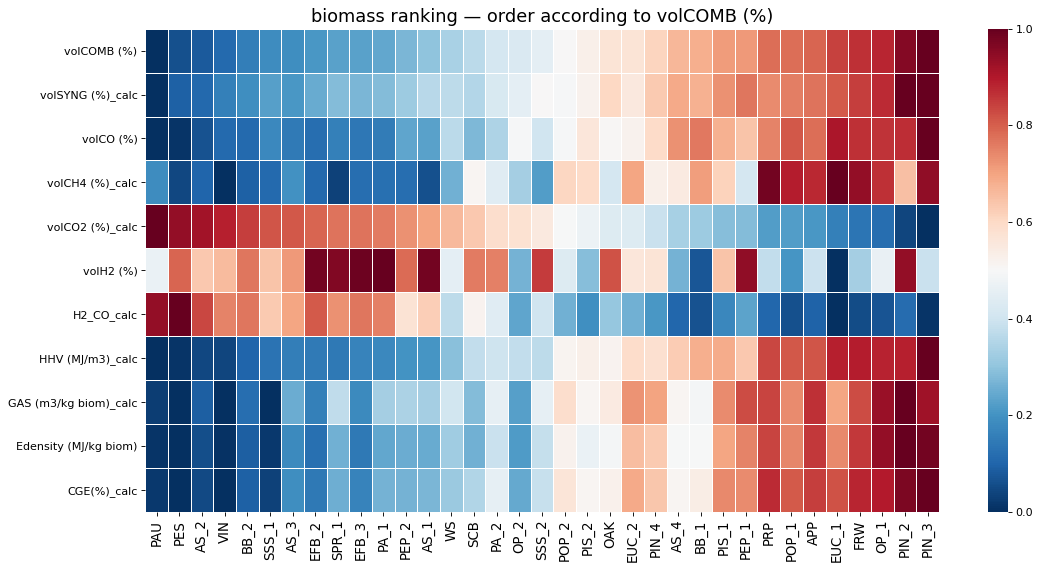

In [471]:
df_order_targets = df_predictions_biomass.iloc[:,[5,4,0,2,3,1,6,7,8,9,10]]
plt.figure(figsize=(16,8), dpi=80)
sns.heatmap(pd.DataFrame.transpose(pd.DataFrame(
    MinMaxScaler().fit_transform(df_order_targets.sort_values('volCOMB (%)', ascending=True)),
    columns=df_order_targets.columns)),
            xticklabels=list(df_predictions_biomass.sort_values('volCOMB (%)')['BIOMASS']),
            yticklabels=df_order_targets.columns,
            cmap='RdBu_r', center=0.5, annot=False, cbar=False, linewidths=0.5, linecolor='white')
plt.title('biomass ranking — order according to volCOMB (%)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
norm = plt.Normalize()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdBu_r'), location='right', aspect=25).outline.set_visible(False) 
#plt.savefig('biomass_ranking_box_COMB.pdf', bbox_inches='tight')
plt.show()

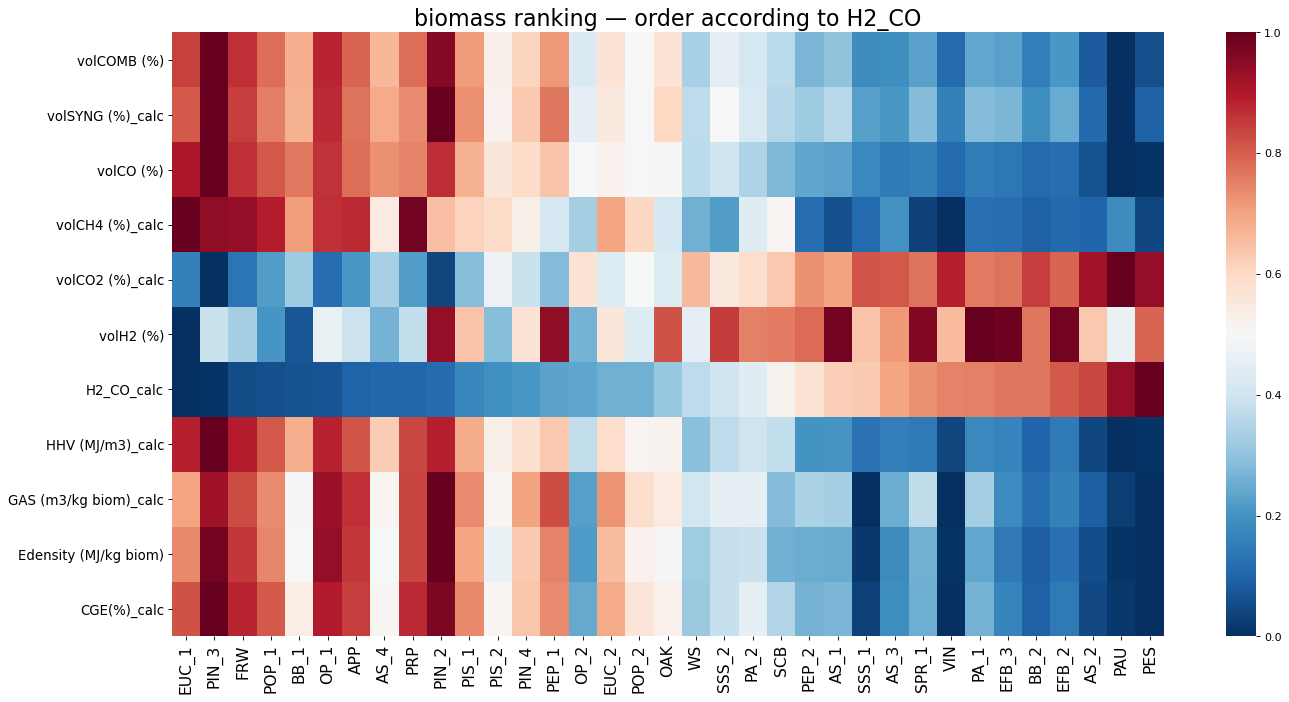

In [503]:
df_order_targets = df_predictions_biomass.iloc[:,[5,4,0,2,3,1,6,7,8,9,10]]
plt.figure(figsize=(20,10), dpi=80)
sns.heatmap(pd.DataFrame.transpose(pd.DataFrame(
    MinMaxScaler().fit_transform(df_order_targets.sort_values('H2_CO_calc', ascending=True)),
    columns=df_order_targets.columns)),
            xticklabels=list(df_predictions_biomass.sort_values('H2_CO_calc')['BIOMASS']),
            yticklabels=df_order_targets.columns,
            cmap='RdBu_r', center=0.5, annot=False)
plt.title('biomass ranking — order according to H2_CO', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
#plt.savefig('biomass_ranking_H2CO.pdf', bbox_inches='tight')
plt.show()

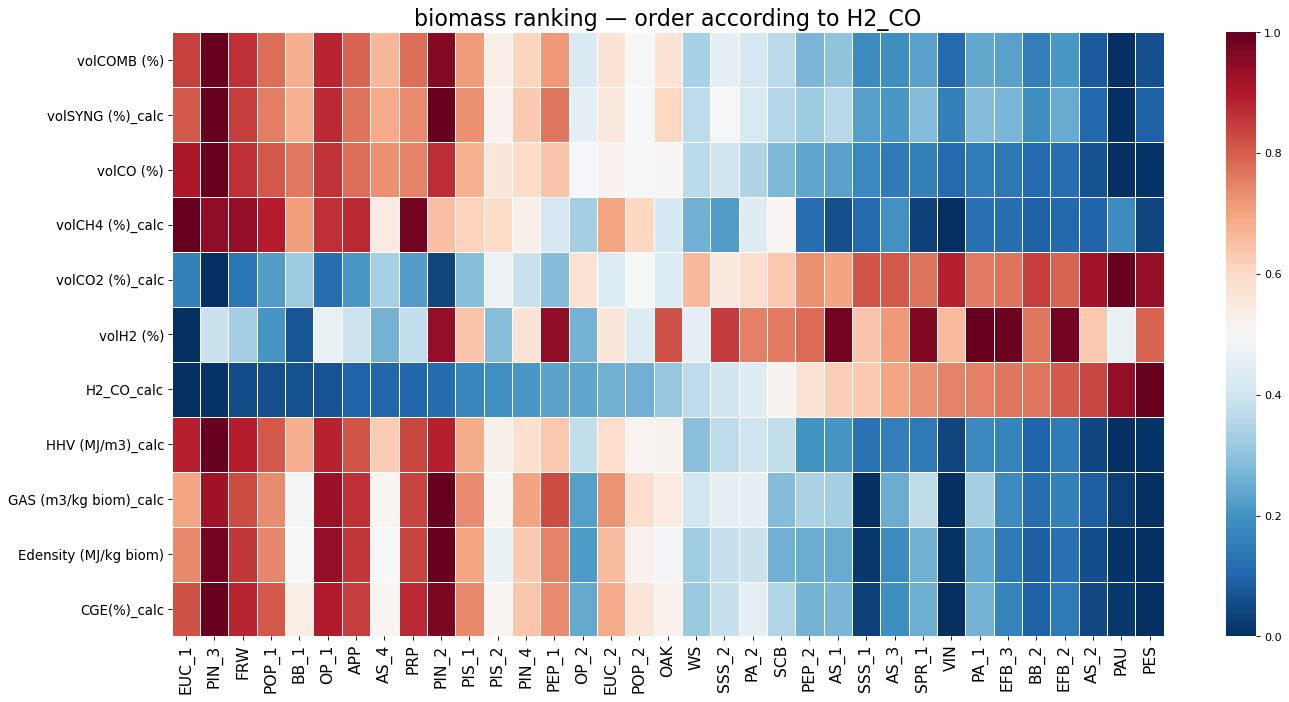

In [504]:
df_order_targets = df_predictions_biomass.iloc[:,[5,4,0,2,3,1,6,7,8,9,10]]
plt.figure(figsize=(20,10), dpi=80)
sns.heatmap(pd.DataFrame.transpose(pd.DataFrame(
    MinMaxScaler().fit_transform(df_order_targets.sort_values('H2_CO_calc', ascending=True)),
    columns=df_order_targets.columns)),
            xticklabels=list(df_predictions_biomass.sort_values('H2_CO_calc')['BIOMASS']),
            yticklabels=df_order_targets.columns,
            cmap='RdBu_r', center=0.5, annot=False, linewidths=0.5, linecolor='white')
plt.title('biomass ranking — order according to H2_CO', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
#plt.savefig('biomass_ranking_box_H2CO.pdf', bbox_inches='tight')
plt.show()

### new_BIOMASSES dataset - feature importance

In [207]:
new_X_scaled = scaling_X(FEATURES_NEWbiomass_12, x_scaler_12)
new_X_scaled = pd.DataFrame(new_X_scaled, columns=FEATURES_NEWbiomass_12.columns)
new_X_scaled.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC(%)
0,0.487411,0.51199,1.049579,0.369274,1.0,-3.722442,0.156741,3.169658,-0.173721,-1.379927,3.581175,1.664764


In [208]:
features

['SA',
 'SBR',
 'HHVbiom (MJ/kg)',
 'T (K)',
 'SR',
 'C (%)',
 'H (%)',
 'O (%)',
 'ash (%)',
 'VM (%)',
 'FC (%)',
 'MC (%)']

In [209]:
outputs

['volCO (%)', 'volH2 (%)', 'volCOMB (%)', 'Edensity (MJ/kg biom)']

In [210]:
model = joblib.load('model_12in4outEden_k6')

#### partial dependence plots

In [211]:
FEATURES_NEWbiomass_12.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC(%)
0,2.33,1.7998,21.1,1173,0.25,43.2489,5.9743,47.5448,1.8448,72.4225,25.7327,11.49


In [212]:
class GPYEstimator:
    """Helper to mimic the interface of sklearn.base.BaseEstimator for partial dependency plots"""

    def __init__(self, model, i, x_scaler_12, y_scaler_4):
        self._fitted = True
        self.fitted_ = True
        self._estimator_type = "regressor"
        self.model = model
        self.i = i
        self.x_scaler_12 = x_scaler_12
        self.y_scaler_4 = y_scaler_4

    def fit(self, X, y):
        ...

    def predict(self, X):
        X = scaling_X(X, self.x_scaler_12)
        y_pred_mu = predict_coregionalized(
            self.model, X, self.i)[0]*sqrt(self.y_scaler_4.var_[self.i]) + self.y_scaler_4.mean_[self.i]
        return y_pred_mu.flatten()

In [213]:
def pdp_plots_new_biomasses(featureX=1, featureY=2):
    n1=0
    n2=1
    n3=2
    n4=3
    features_plot=[(featureX, featureY)]
    model_CO = GPYEstimator(model, n1, x_scaler_12, y_scaler_4)
    model_H2 = GPYEstimator(model, n2, x_scaler_12, y_scaler_4)
    model_COMB = GPYEstimator(model, n3, x_scaler_12, y_scaler_4)
    model_Edens = GPYEstimator(model, n4, x_scaler_12, y_scaler_4)

    contour_kw = {
        'cmap': 'RdBu_r',
        'alpha': 0.8,
        'linewidth': 1.5,
        'linestyle': 'solid'
    }

    fig, ax = plt.subplots(1, 4, figsize=(10,5), sharey=True)

    PartialDependenceDisplay.from_estimator(estimator=model_CO, X=FEATURES_NEWbiomass_12, features=features_plot, ax=[ax[0]], 
                                            contour_kw=contour_kw)
    ax[0].set_title(outputs[n1], fontsize=14)

    PartialDependenceDisplay.from_estimator(estimator=model_H2, X=FEATURES_NEWbiomass_12, features=features_plot, ax=[ax[1]], 
                                            contour_kw=contour_kw)
    ax[1].set_title(outputs[n2], fontsize=14)
    ax[1].set_ylabel(None)

    PartialDependenceDisplay.from_estimator(estimator=model_COMB, X=FEATURES_NEWbiomass_12, features=features_plot, ax=[ax[2]], 
                                            contour_kw=contour_kw)
    ax[2].set_title(outputs[n3], fontsize=14)
    ax[2].set_ylabel(None)
    
    PartialDependenceDisplay.from_estimator(estimator=model_Edens, X=FEATURES_NEWbiomass_12, features=features_plot, 
                                            ax=[ax[3]], contour_kw=contour_kw)
    ax[3].set_title(outputs[n4], fontsize=14)
    ax[3].set_ylabel(None)

    fig.tight_layout(w_pad=1.5)
    plt.show()

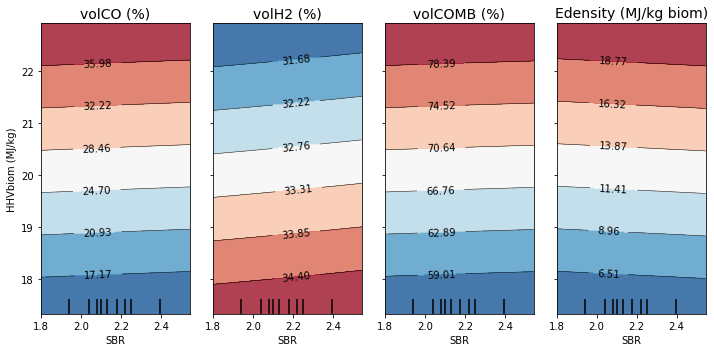

In [214]:
pdp_plots_new_biomasses(featureX=1, featureY=2)

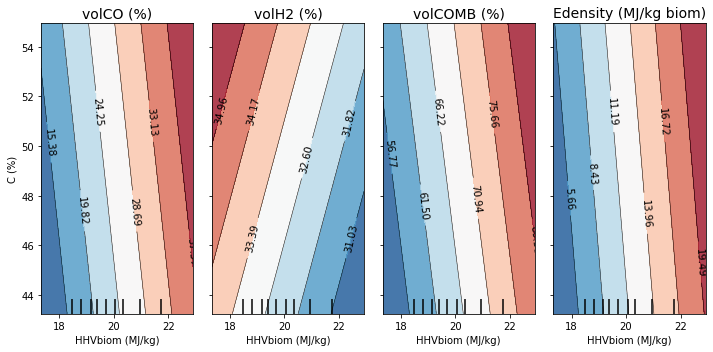

In [215]:
pdp_plots_new_biomasses(featureX=2, featureY=5)

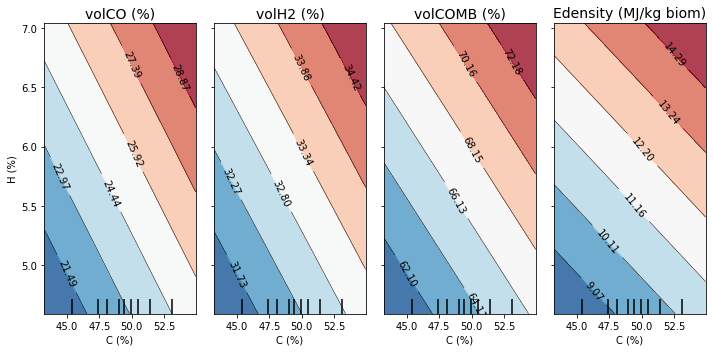

In [216]:
pdp_plots_new_biomasses(featureX=5, featureY=6)

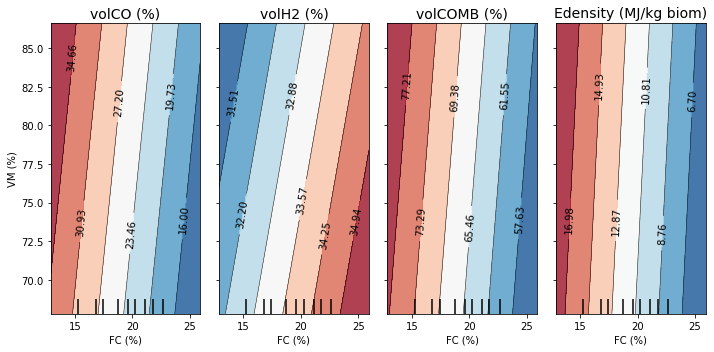

In [219]:
pdp_plots_new_biomasses(featureX=10, featureY=9)

#### SHAP summary plots

In [223]:
n_output=0
shap_values_CO = get_shap_values(model, new_X_scaled.values, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.71it/s]


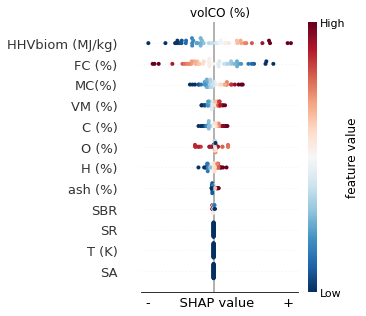

In [224]:
n_output=0
shap.summary_plot(shap_values=shap_values_CO, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

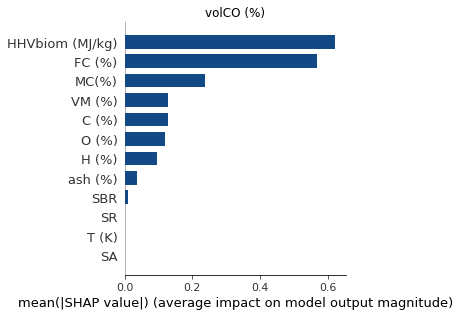

In [225]:
n_output=0
shap.summary_plot(shap_values=shap_values_CO, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(outputs[n_output])
plt.tight_layout()
plt.show()

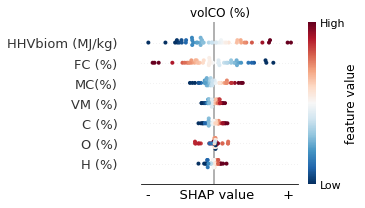

In [226]:
n_output=0
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_CO[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(20)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

In [227]:
n_output=1
shap_values_H2 = get_shap_values(model, new_X_scaled.values, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.76it/s]


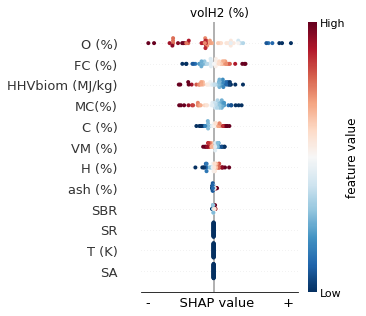

In [228]:
n_output=1
shap.summary_plot(shap_values=shap_values_H2, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

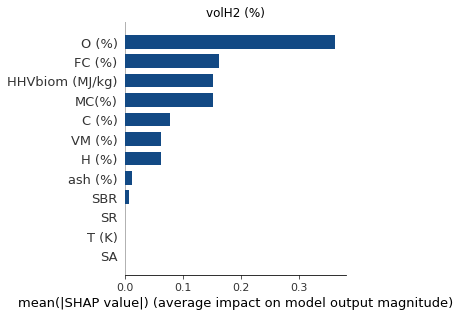

In [229]:
n_output=1
shap.summary_plot(shap_values=shap_values_H2, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(outputs[n_output])
plt.tight_layout()
plt.show()

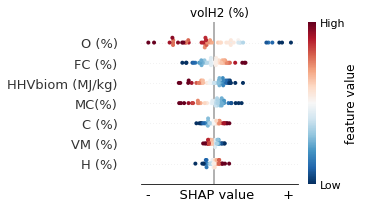

In [230]:
n_output=1
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_H2[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(20)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

In [231]:
n_output=2
shap_values_COMB = get_shap_values(model, new_X_scaled.values, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.80it/s]


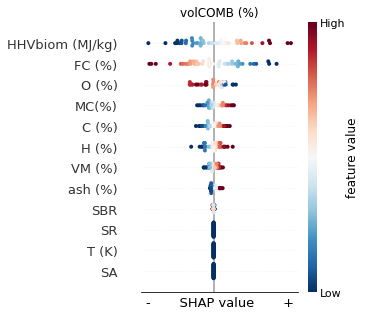

In [232]:
n_output=2
shap.summary_plot(shap_values=shap_values_COMB, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

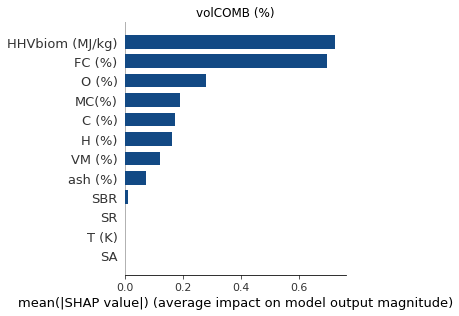

In [233]:
n_output=2
shap.summary_plot(shap_values=shap_values_COMB, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(outputs[n_output])
plt.tight_layout()
plt.show()

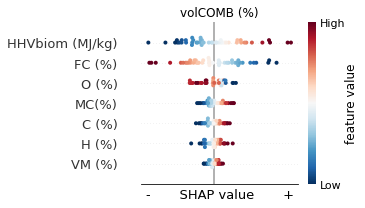

In [234]:
n_output=2
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_COMB[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(20)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

In [235]:
n_output=3
shap_values_Edens = get_shap_values(model, new_X_scaled.values, index=n_output,
                                    custom_wrapper=None, coregionalized=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.72it/s]


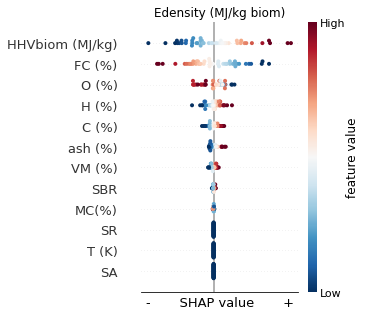

In [236]:
n_output=3
shap.summary_plot(shap_values=shap_values_Edens, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

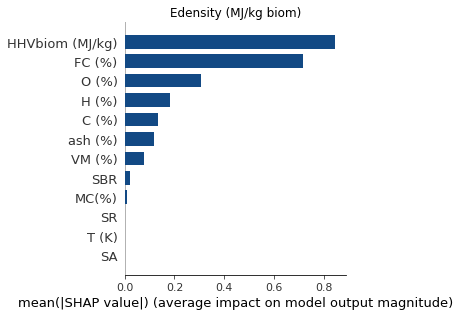

In [237]:
n_output=3
shap.summary_plot(shap_values=shap_values_Edens, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(outputs[n_output])
plt.tight_layout()
plt.show()

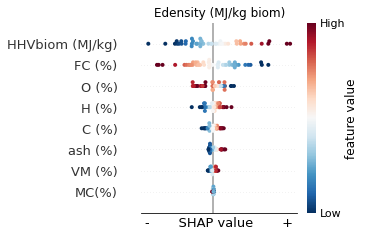

In [238]:
n_output=3
index = [2,5,6,7,8,9,10,11]
shap.summary_plot(shap_values=shap_values_Edens[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3.4),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(outputs[n_output])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(20)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculated outputs NEW_BIOMASSES

In [239]:
TARGETS_GASIF_11.head(1)

,volCO2 (%),volCO (%),volCH4 (%),volH2 (%),volCOMB (%),volSYNG (%),H2_CO,HHV (MJ/m3),CGE (%),Edensity (MJ/kg biom),GAS (m3/kg biom)
0,32.5244,23.6541,7.3919,36.4296,67.4756,60.0837,1.5401,9.8471,40.1364,7.8526,0.7975


In [240]:
y_scaled_11 = scaling_X(TARGETS_GASIF_11, y_scaler_11)
y_scaled_11 = pd.DataFrame(y_scaled_11, columns=TARGETS_GASIF_11.columns)
y_scaled_11.head(1)

,volCO2 (%),volCO (%),volCH4 (%),volH2 (%),volCOMB (%),volSYNG (%),H2_CO,HHV (MJ/m3),CGE (%),Edensity (MJ/kg biom),GAS (m3/kg biom)
0,0.708193,-0.923521,-1.49435,1.003296,-0.708193,-0.45497,0.669383,-1.014252,-1.098756,-1.110626,-1.038393


#### calculation of CH4 predictions

In [242]:
TARGETS_GASIF_11.columns[2]

'volCH4 (%)'

In [243]:
def custom_wrapper_CH4(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_calc_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_calc_mu_CH4_scaled = ((y_calc_mu_CH4 - y_scaler_11.mean_[2])/sqrt(y_scaler_11.var_[2])).flatten() 
    return y_calc_mu_CH4_scaled

In [244]:
shap_values_CH4 = get_shap_values(model, new_X_scaled.values, 
                                  custom_wrapper=custom_wrapper_CH4)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:22<00:00,  2.13it/s]


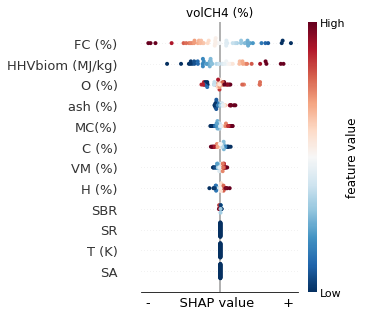

In [245]:
n=2
shap.summary_plot(shap_values=shap_values_CH4, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

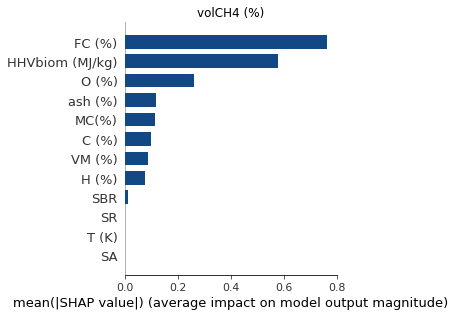

In [246]:
n=2
shap.summary_plot(shap_values=shap_values_CH4, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

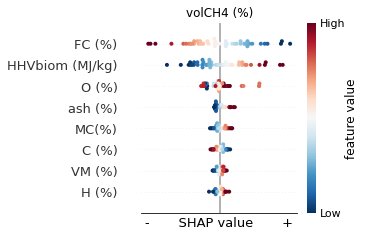

In [247]:
n_output=2
index = [2,5,6,7,8,9,10,11]
shap.summary_plot(shap_values=shap_values_CH4[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3.4),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(20)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculation of volSYNG predictions

In [248]:
TARGETS_GASIF_11.columns[5]

'volSYNG (%)'

In [249]:
def custom_wrapper_SYNG(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_calc_mu_SYNG = y_pred_mu_CO + y_pred_mu_H2
    y_calc_mu_SYNG_scaled = ((y_calc_mu_SYNG - y_scaler_11.mean_[5])/sqrt(y_scaler_11.var_[5])).flatten() 
    return y_calc_mu_SYNG_scaled

In [250]:
shap_values_SYNG = get_shap_values(model, new_X_scaled.values, 
                                   custom_wrapper=custom_wrapper_SYNG, coregionalized=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.77it/s]


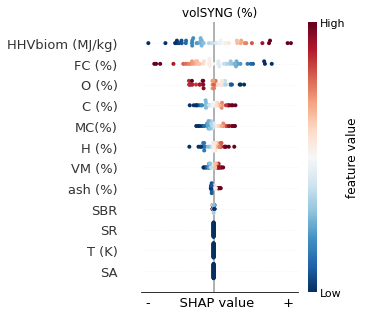

In [251]:
n=5
shap.summary_plot(shap_values=shap_values_SYNG, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

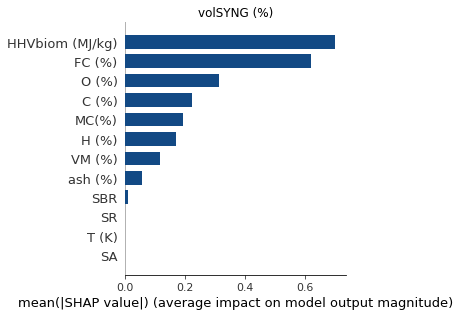

In [252]:
n=5
shap.summary_plot(shap_values=shap_values_SYNG, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

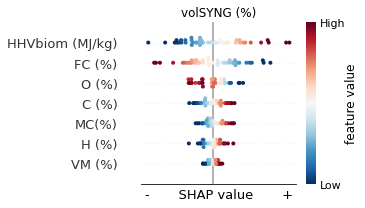

In [253]:
n=5
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_SYNG[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(16)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculation of H2/CO predictions

In [254]:
TARGETS_GASIF_11.columns[6]

'H2_CO'

In [255]:
def custom_wrapper_H2CO(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_calc_mu_H2CO = y_pred_mu_H2 / y_pred_mu_CO
    y_calc_mu_H2CO_scaled = ((y_calc_mu_H2CO - y_scaler_11.mean_[6])/sqrt(y_scaler_11.var_[6])).flatten() 
    return y_calc_mu_H2CO_scaled

In [256]:
shap_values_H2CO = get_shap_values(model, new_X_scaled.values, 
                                   custom_wrapper=custom_wrapper_H2CO, coregionalized=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:17<00:00,  2.72it/s]


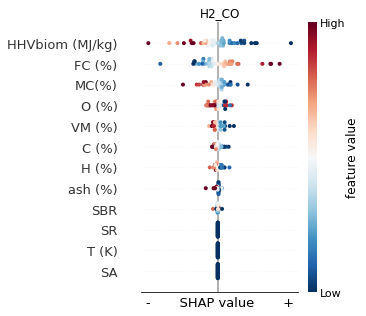

In [257]:
n=6
shap.summary_plot(shap_values=shap_values_H2CO, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

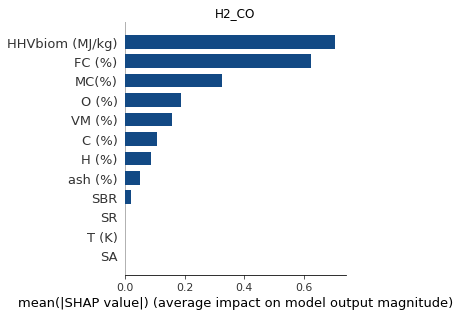

In [258]:
n=6
shap.summary_plot(shap_values=shap_values_H2CO, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

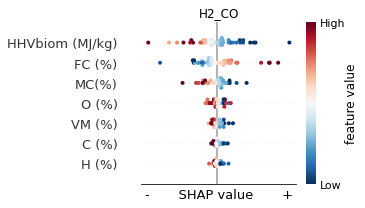

In [259]:
n=6
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_H2CO[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(16)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculation of HHV predictions

In [260]:
TARGETS_GASIF_11.columns[7]

'HHV (MJ/m3)'

In [261]:
def custom_wrapper_HHV(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_calc_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_calc_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_calc_mu_CH4)/100
    y_calc_mu_HHV_scaled = ((y_calc_mu_HHV - y_scaler_11.mean_[7])/sqrt(y_scaler_11.var_[7])).flatten()
    return y_calc_mu_HHV_scaled

In [262]:
shap_values_HHV = get_shap_values(model, new_X_scaled.values, 
                                  custom_wrapper=custom_wrapper_HHV, coregionalized=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:23<00:00,  1.96it/s]


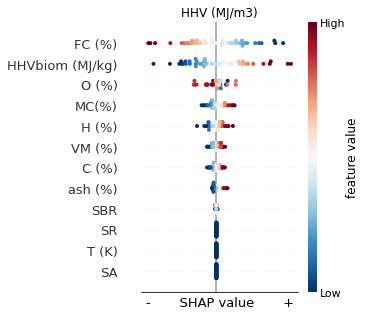

In [263]:
n=7
shap.summary_plot(shap_values=shap_values_HHV, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

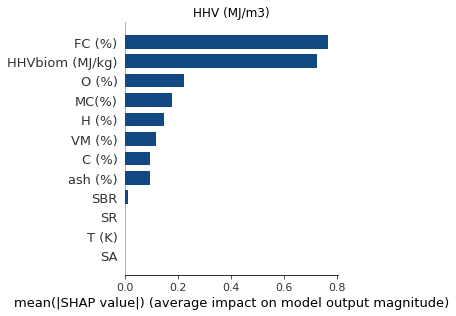

In [264]:
n=7
shap.summary_plot(shap_values=shap_values_HHV, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

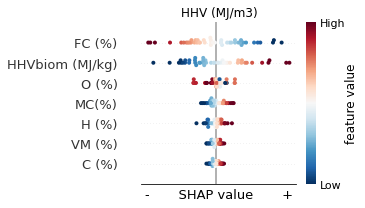

In [265]:
n=7
index = [2,5,6,7,9,10,11]
shap.summary_plot(shap_values=shap_values_HHV[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(16)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculation of GAS predictions

In [266]:
TARGETS_GASIF_11.columns[10]

'GAS (m3/kg biom)'

In [267]:
def custom_wrapper_GAS(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_calc_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_calc_mu_HHV = (11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_calc_mu_CH4)/100
    y_pred_mu_Edens = predict_coregionalized(model, X, 3)[0]*sqrt(y_scaler_11.var_[9]) + y_scaler_11.mean_[9] 
    y_calc_mu_GAS = y_pred_mu_Edens / y_calc_mu_HHV
    y_calc_mu_GAS_scaled = ((y_calc_mu_GAS - y_scaler_11.mean_[10])/sqrt(y_scaler_11.var_[10])).flatten() 
    return y_calc_mu_GAS_scaled

In [269]:
shap_values_GAS = get_shap_values(model, new_X_scaled.values, 
                                  custom_wrapper=custom_wrapper_GAS, coregionalized=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:29<00:00,  1.60it/s]


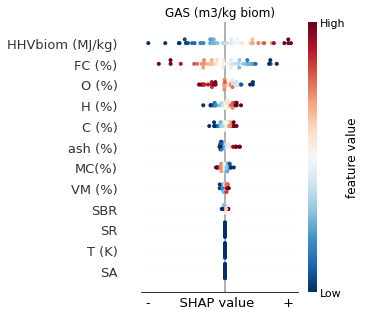

In [270]:
n=10
shap.summary_plot(shap_values=shap_values_GAS, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

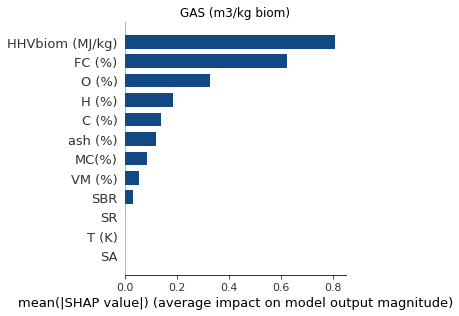

In [271]:
n=10
shap.summary_plot(shap_values=shap_values_GAS, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

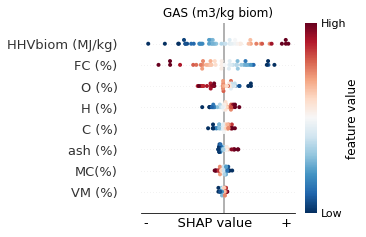

In [272]:
n=10
index = [2,5,6,7,8,9,10,11]
shap.summary_plot(shap_values=shap_values_GAS[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3.4),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(16)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

#### calculation of CGE predictions

In [273]:
TARGETS_GASIF_11.columns[8]

'CGE (%)'

In [278]:
def custom_wrapper_CGE(model, X):
    y_pred_mu_CO = predict_coregionalized(model, X, 0)[0]*sqrt(y_scaler_11.var_[1]) + y_scaler_11.mean_[1]
    y_pred_mu_H2 = predict_coregionalized(model, X, 1)[0]*sqrt(y_scaler_11.var_[3]) + y_scaler_11.mean_[3]
    y_pred_mu_COMB = predict_coregionalized(model, X, 2)[0]*sqrt(y_scaler_11.var_[4]) + y_scaler_11.mean_[4]
    y_calc_mu_CH4 = y_pred_mu_COMB - y_pred_mu_CO - y_pred_mu_H2
    y_calc_mu_HHV = ((11.76*y_pred_mu_CO + 11.882*y_pred_mu_H2 + 37.024*y_calc_mu_CH4)/100).flatten()
    y_pred_mu_Edens = predict_coregionalized(model, X, 3)[0]*sqrt(y_scaler_11.var_[9]) + y_scaler_11.mean_[9]
    HHVbiom = FEATURES_NEWbiomass_12['HHVbiom (MJ/kg)'].values
    y_calc_mu_CGE = y_pred_mu_Edens.flatten() / HHVbiom*100
    y_calc_mu_CGE_scaled = ((y_calc_mu_CGE - y_scaler_11.mean_[8])/sqrt(y_scaler_11.var_[8])).flatten()
    return y_calc_mu_CGE_scaled

In [279]:
shap_values_CGE = get_shap_values(model, new_X_scaled.values, 
                                  custom_wrapper=custom_wrapper_CGE, coregionalized=False)

  0%|                                                                                            | 0/47 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (23970,) (47,) 

In [ ]:
n=8
shap.summary_plot(shap_values=shap_values_CGE, features=new_X_scaled, 
                  max_display=14, plot_type='dot', plot_size=(5,4.5),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(30)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()

In [ ]:
n=8
shap.summary_plot(shap_values=shap_values_CGE, features=new_X_scaled, 
                  max_display=14, plot_type='bar', plot_size=(5,4.5),
                  show=False, color='#124984')
plt.title(TARGETS_GASIF_11.columns[n])
plt.tight_layout()
plt.show()

In [ ]:
n=8
index = [2,5,6,7,8,9,10,11]
shap.summary_plot(shap_values=shap_values_CGE[:,index],
                  features=new_X_scaled.iloc[:,index], 
                  max_display=14, plot_type='dot', plot_size=(5,3.4),
                  show=False, cmap='RdBu_r', color_bar_label='feature value')
plt.title(TARGETS_GASIF_11.columns[n])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(16)
plt.xlabel('-       SHAP value       +')
plt.xticks(ticks=())
plt.tight_layout()
plt.show()